<div style="
    background-color: #1e0644;
    padding: 8px;
    border-style: solid;
    font-family: 'Comic Sans MS', cursive;
    color: #FFFFFF;
    font-size: 200%;
    text-align: center;
    font-weight: bold;
">
    California Telecom Churn Prediction
</div>

<img src="https://www.cleartouch.in/wp-content/uploads/2022/11/Customer-Churn.png" 
     alt="Customer Churn" 
     style="width: 100%; margin: 0; padding: 0;" >

# Packages

In [1379]:
from pathlib import Path

import dill
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pendulum
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from imblearn.pipeline import Pipeline as imb_Pipeline
from loguru import logger
from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             RocCurveDisplay,
                             PrecisionRecallDisplay,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from ucimlrepo import fetch_ucirepo, list_available_datasets
from yellowbrick.classifier import DiscriminationThreshold

set_config(display='diagram')
pd.set_option("display.max_columns", None)

In [1786]:
import warnings
warnings.filterwarnings('ignore')

<div style="
    background-color: #8333ff;
    padding: 8px;
    border-style: solid;
    font-family: 'Comic Sans MS', cursive;
    color: #FFFFFF;
    font-size: 170%;
    text-align: center;
    font-weight: bold;
">
    DATA VIEW
</div>

In [1788]:
data_churn = pd.read_csv("TP_ML2/telecom_customer_churn.csv", sep=",")
zipcode=pd.read_csv("TP_ML2/telecom_zipcode_population.csv", sep=",")
metadata=pd.read_csv("TP_ML2/telecom_data_dictionary.csv", encoding='latin-1')

# Metadata

In [1790]:
metadata

,Table,Field,Description
0,Customer Churn,CustomerID,A unique ID that identifies each customer
1,Customer Churn,Gender,"The customers gender: Male, Female"
2,Customer Churn,Age,"The customers current age, in years, at the t..."
3,Customer Churn,Married,"Indicates if the customer is married: Yes, No"
4,Customer Churn,Number of Dependents,Indicates the number of dependents that live w...
5,Customer Churn,City,The city of the customers primary residence i...
6,Customer Churn,Zip Code,The zip code of the customers primary residence
7,Customer Churn,Latitude,The latitude of the customers primary residence
8,Customer Churn,Longitude,The longitude of the customers primary residence
9,Customer Churn,Number of Referrals,Indicates the number of times the customer has...


## Data

In [1792]:
data_churn.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,NaN,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,NaN,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,NaN,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [1794]:
data_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

<div style="
    background-color: #8333ff;
    padding: 8px;
    border-style: solid;
    font-family: 'Comic Sans MS', cursive;
    color: #FFFFFF;
    font-size: 170%;
    text-align: center;
    font-weight: bold;
">
    EDA
</div>

### Duplicates data

In [1796]:
data_churn = data_churn.drop(['Customer ID'], axis=1)

In [1798]:
data_churn.duplicated().sum()

0

### Missing data

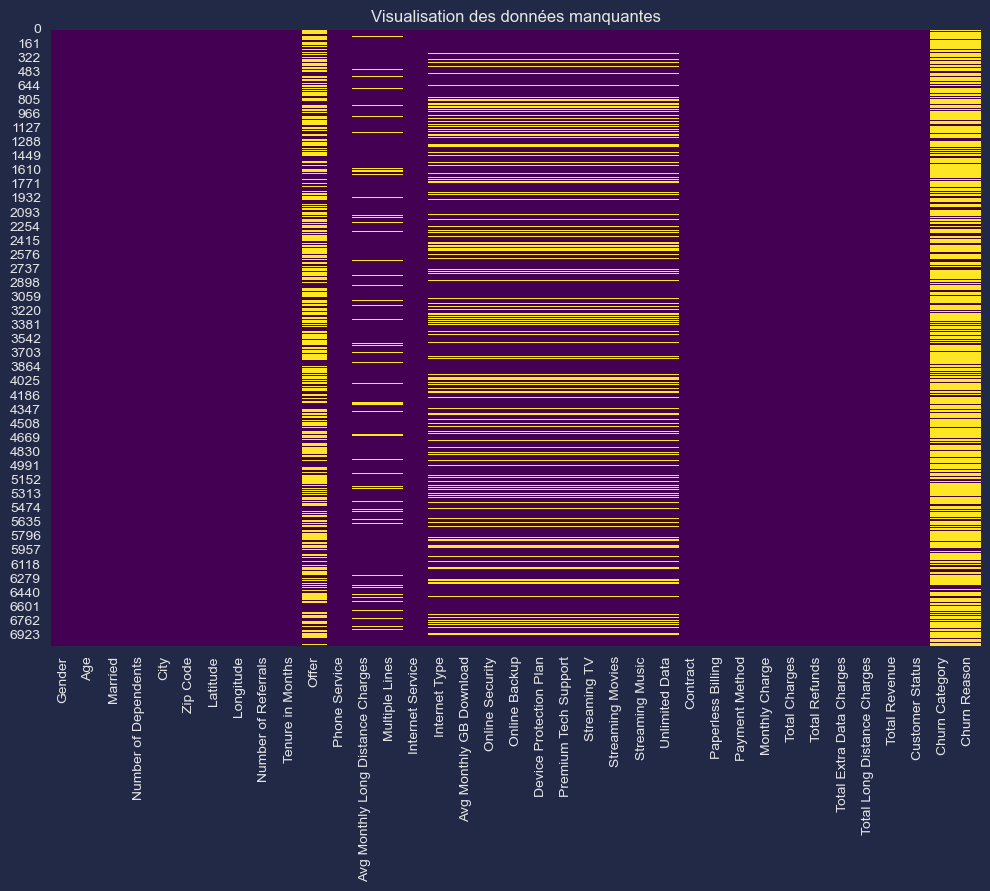

In [1802]:
# Taille de la figure
plt.figure(figsize=(12, 8))
# Heatmap des valeurs manquantes
sns.heatmap(data_churn.isnull(), cbar=False, cmap='viridis')
plt.title('Visualisation des données manquantes')
plt.show()

# Variables qualitatives

In [1835]:
vars_quali = data_churn.select_dtypes(exclude='number')
vars_quali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  7043 non-null   object
 1   Married                 7043 non-null   object
 2   City                    7043 non-null   object
 3   Offer                   3166 non-null   object
 4   Phone Service           7043 non-null   object
 5   Multiple Lines          6361 non-null   object
 6   Internet Service        7043 non-null   object
 7   Internet Type           5517 non-null   object
 8   Online Security         5517 non-null   object
 9   Online Backup           5517 non-null   object
 10  Device Protection Plan  5517 non-null   object
 11  Premium Tech Support    5517 non-null   object
 12  Streaming TV            5517 non-null   object
 13  Streaming Movies        5517 non-null   object
 14  Streaming Music         5517 non-null   object
 15  Unli

In [2021]:
vars_quali.describe().T

,count,unique,top,freq
Gender,7043,2,Male,3555
Married,7043,2,No,3641
City,7043,1106,Los Angeles,293
Offer,7043,6,No,3877
Phone Service,7043,2,Yes,6361
Multiple Lines,7043,2,No,4072
Internet Service,7043,2,Yes,5517
Internet Type,7043,4,Fiber Optic,3035
Online Security,7043,2,No,5024
Online Backup,7043,2,No,4614


In [1837]:
vars_quali = vars_quali.drop(['Churn Category', 'Churn Reason'], axis=1)

In [1823]:
for col in vars_quali.columns:
    print(vars_quali[col].value_counts())
    print("Nbre modalités :", vars_quali[col].nunique())
    print("-" * 40)

Gender
Male      3555
Female    3488
Name: count, dtype: int64
Nbre modalités : 2
----------------------------------------
Married
No     3641
Yes    3402
Name: count, dtype: int64
Nbre modalités : 2
----------------------------------------
City
Los Angeles         293
San Diego           285
San Jose            112
Sacramento          108
San Francisco       104
                   ... 
Johannesburg          2
South Lake Tahoe      2
Jacumba               2
Holtville             2
Eldridge              2
Name: count, Length: 1106, dtype: int64
Nbre modalités : 1106
----------------------------------------
Offer
Offer B    824
Offer E    805
Offer D    602
Offer A    520
Offer C    415
Name: count, dtype: int64
Nbre modalités : 5
----------------------------------------
Phone Service
Yes    6361
No      682
Name: count, dtype: int64
Nbre modalités : 2
----------------------------------------
Multiple Lines
No     3390
Yes    2971
Name: count, dtype: int64
Nbre modalités : 2
------------

#### Visualisation graphique

In [1997]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use('default')

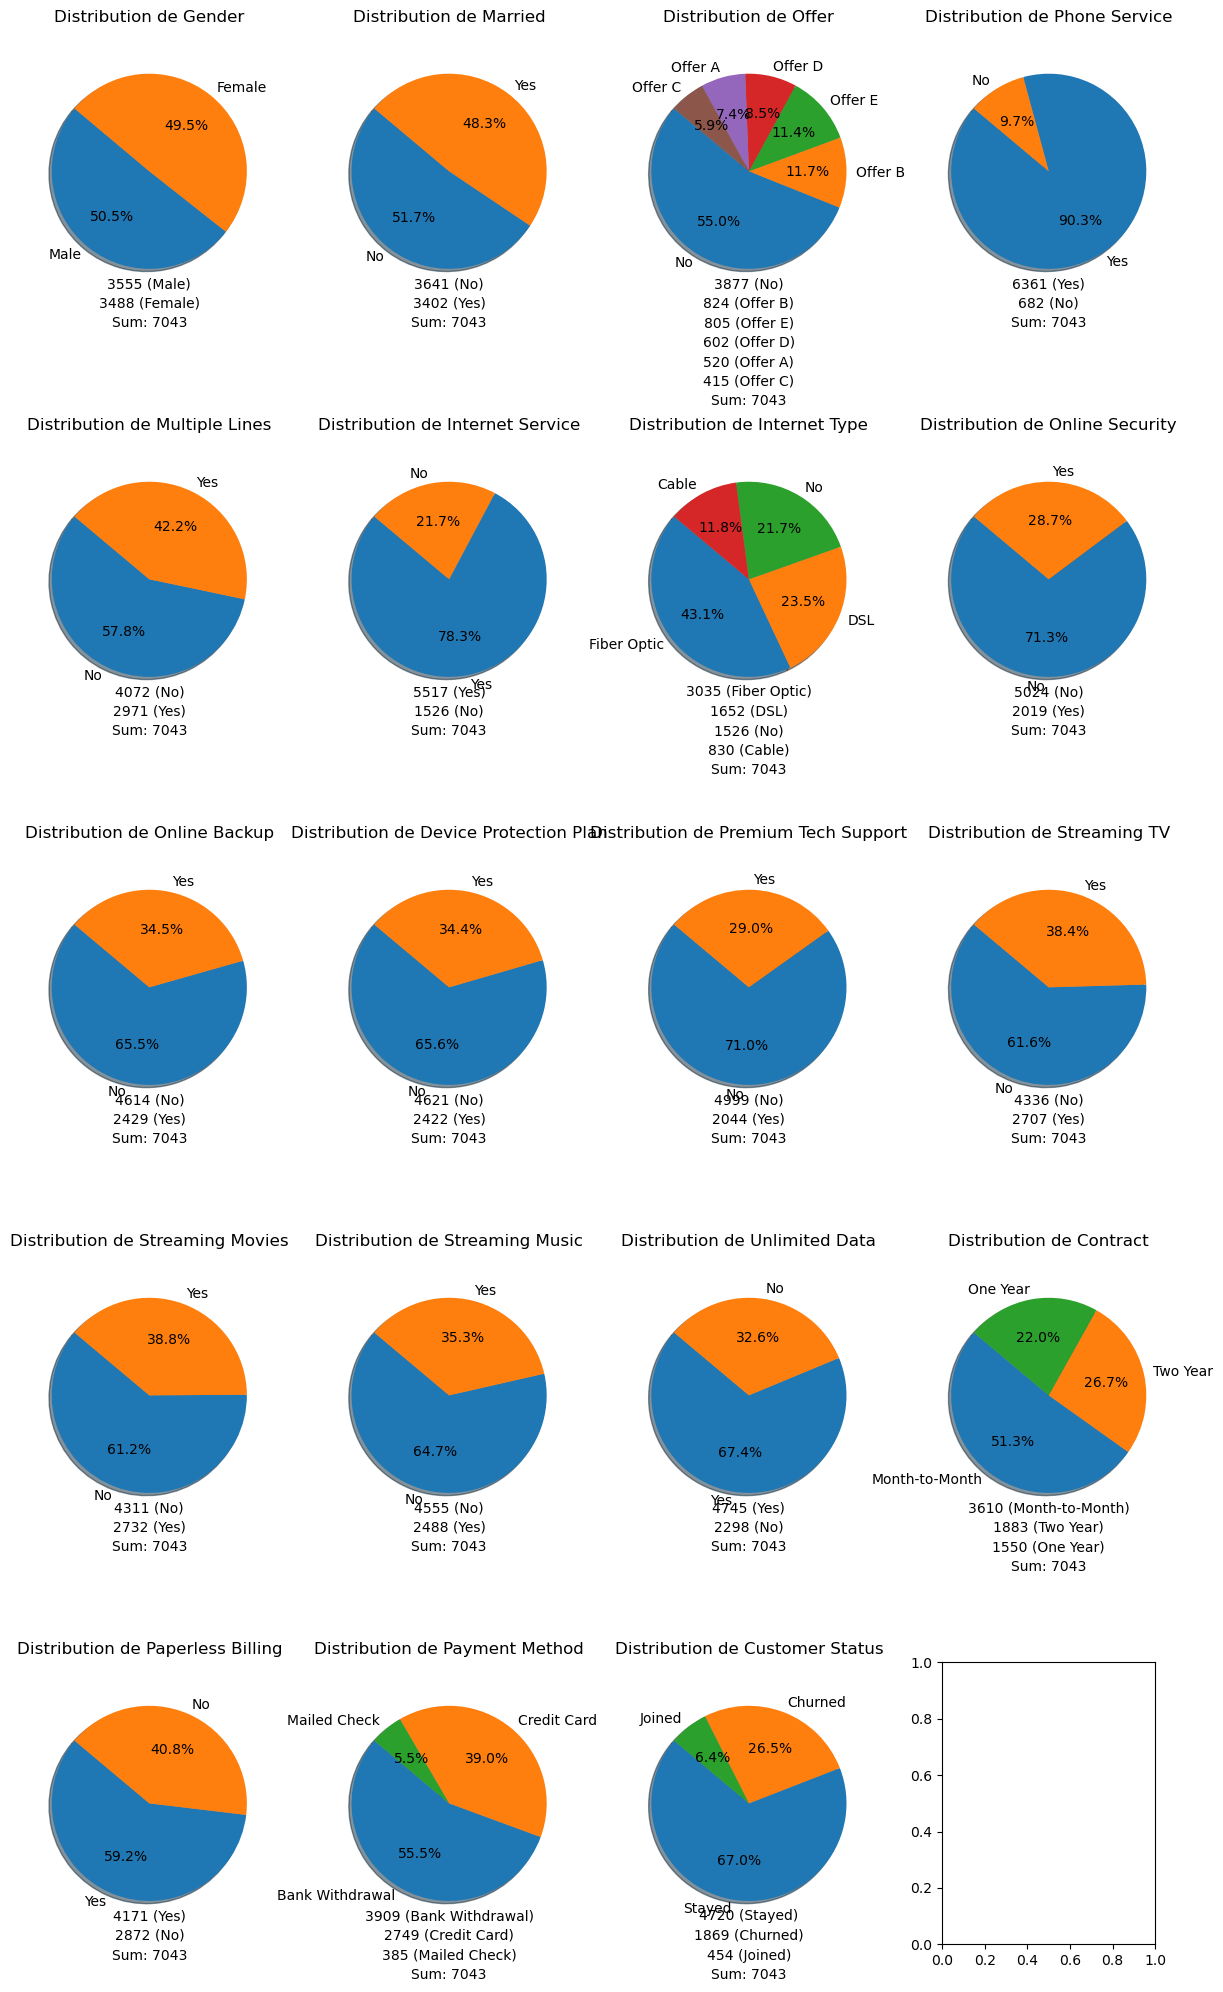

In [1999]:
# Diagrammes circulaires
vars_quali1 = vars_quali.drop(['City'], axis=1)
num_rows = 5
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

for i, column in enumerate(vars_quali1.columns):
    categories = vars_quali1[column].value_counts()

    ax = axes[i // num_cols, i % num_cols]

    ax.pie(categories, labels=categories.index, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal')
    ax.set_title(f'Distribution de {column}')

    # Ajout des annotations 
    total = categories.values.sum()
    sum_text = f'Sum: {total}'
    ax.text(0, -1.2 - len(categories)*0.2, sum_text, ha='center')

    for j, percentage in enumerate(categories):
        percent_text = f'{percentage} ({categories.index[j]})'
        ax.text(0, -1.2 - j*0.2, percent_text, ha='center')

plt.tight_layout()
plt.show()

In [1841]:
data_churn["Churn_Binary"] = data_churn["Customer Status"].apply(lambda x: "Churned" if x == "Churned" else "Non Churned")

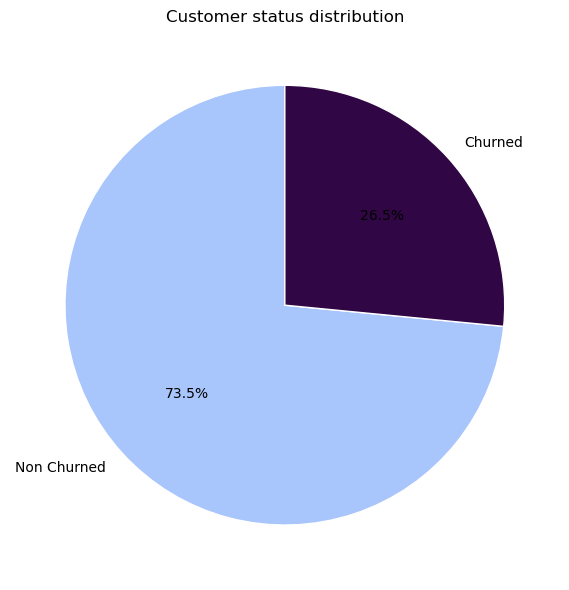

In [2001]:
# Regrouper les données
label_distribution = data_churn['Churn_Binary'].value_counts()

colors = ['#a8c5fc','#300644']  

plt.figure(figsize=(6, 6))
plt.pie(
    label_distribution, 
    labels=label_distribution.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)

plt.title('Customer status distribution')
plt.tight_layout()
plt.show()

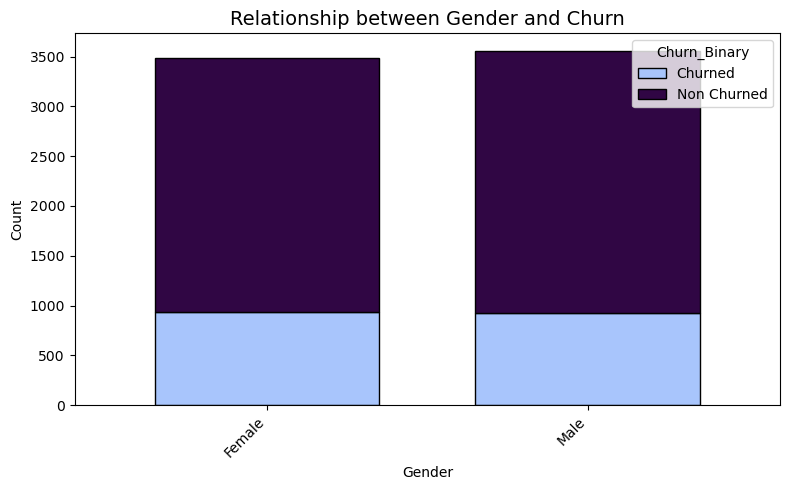

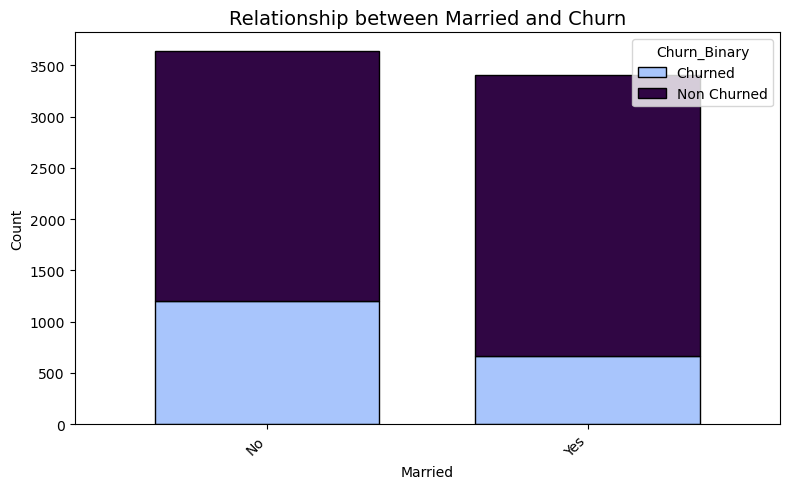

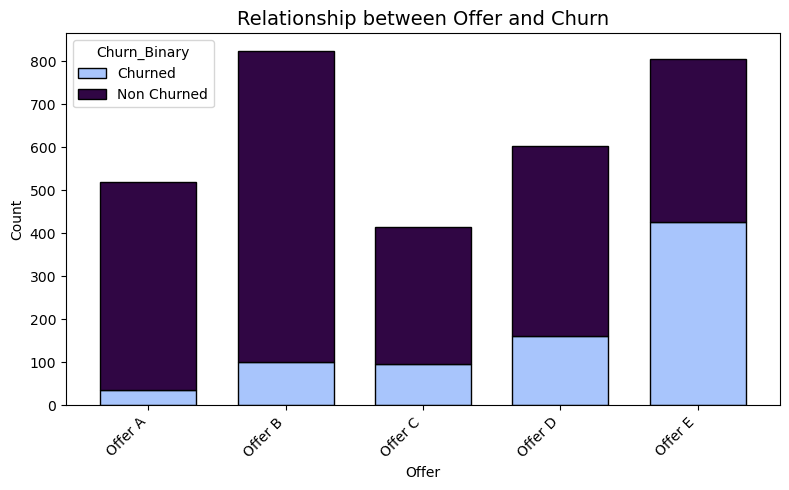

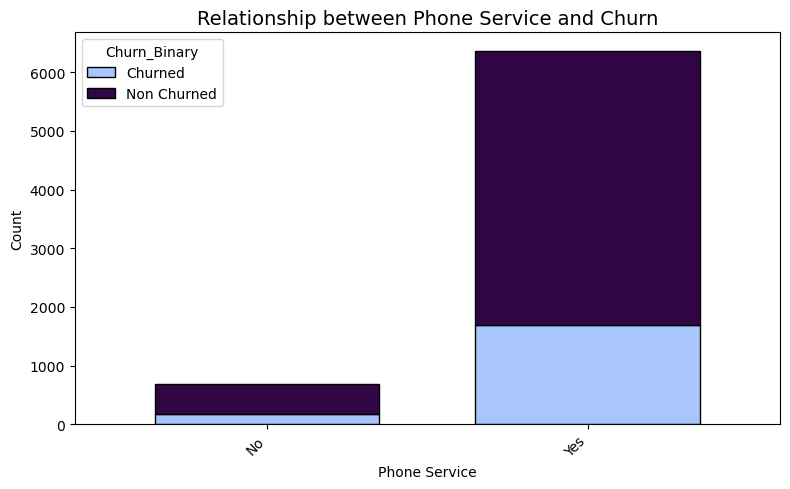

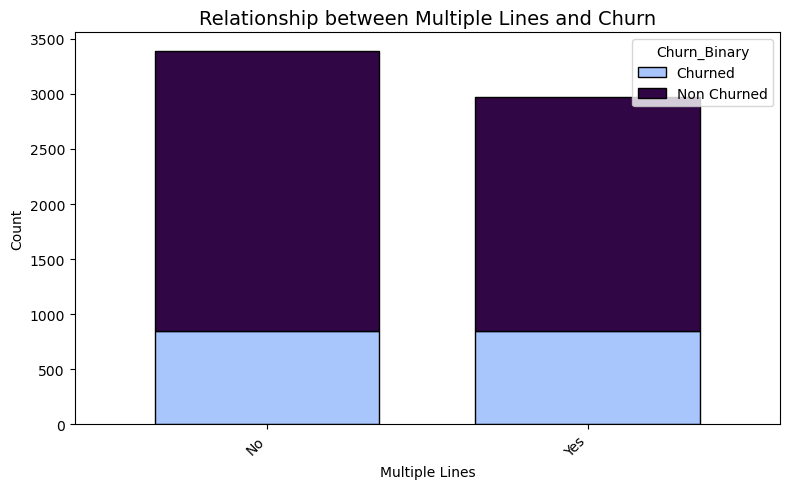

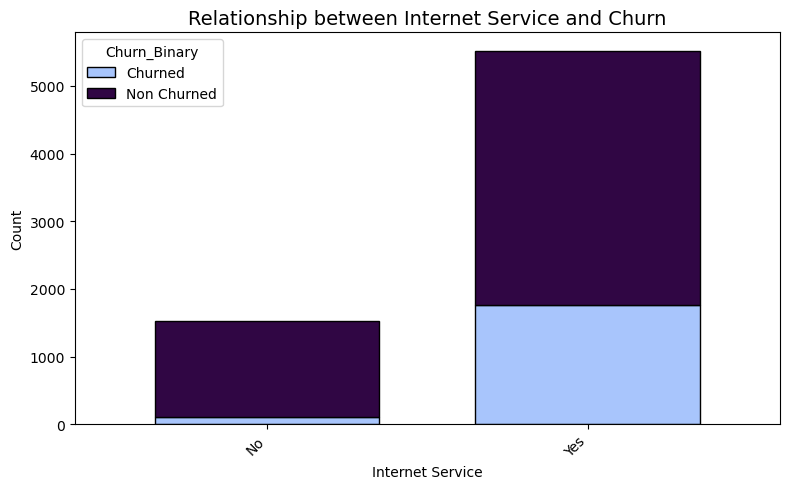

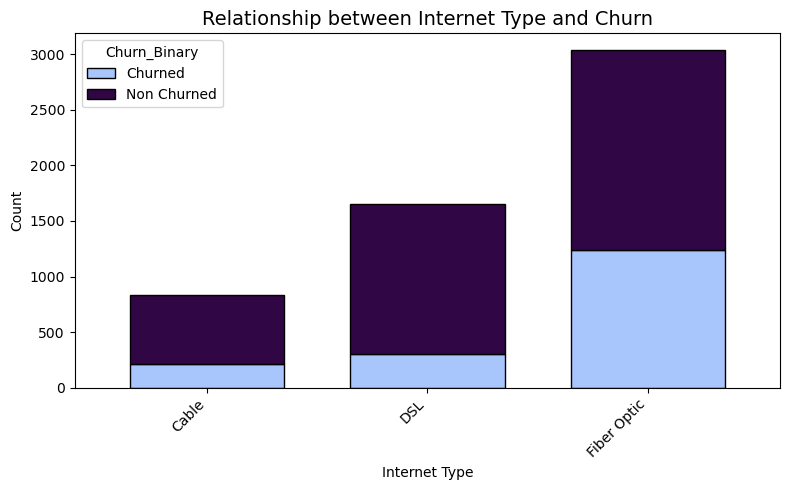

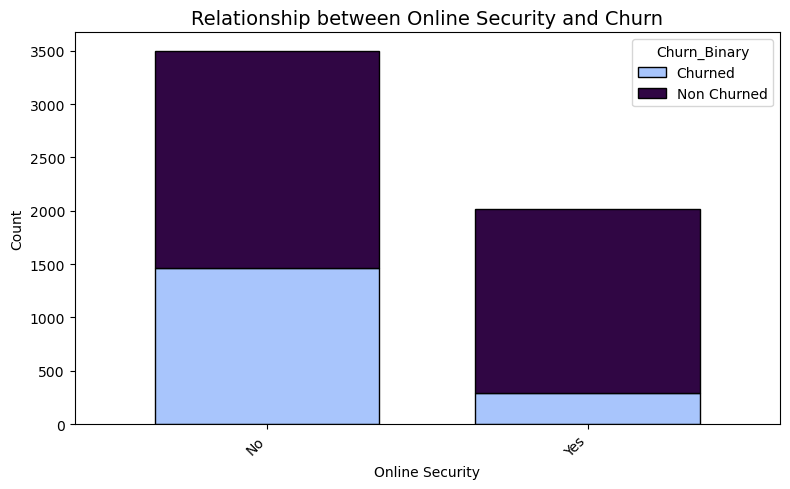

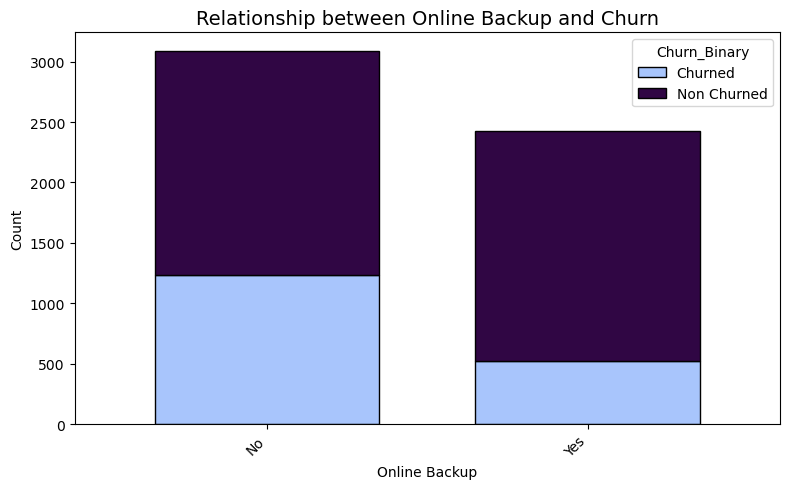

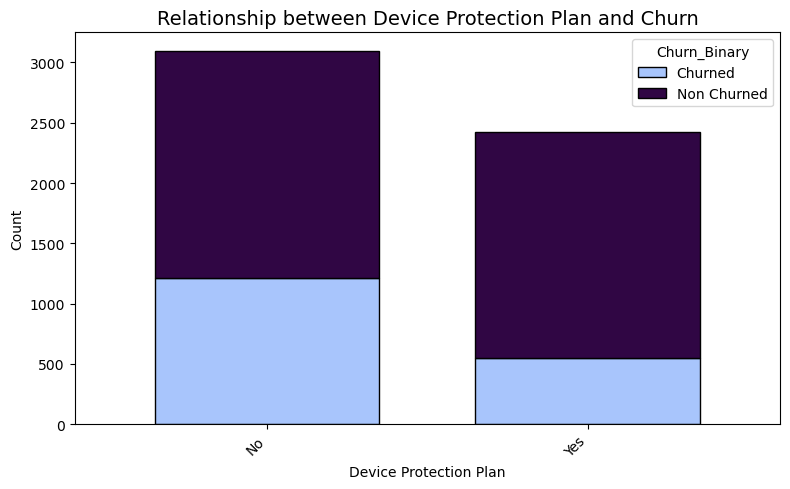

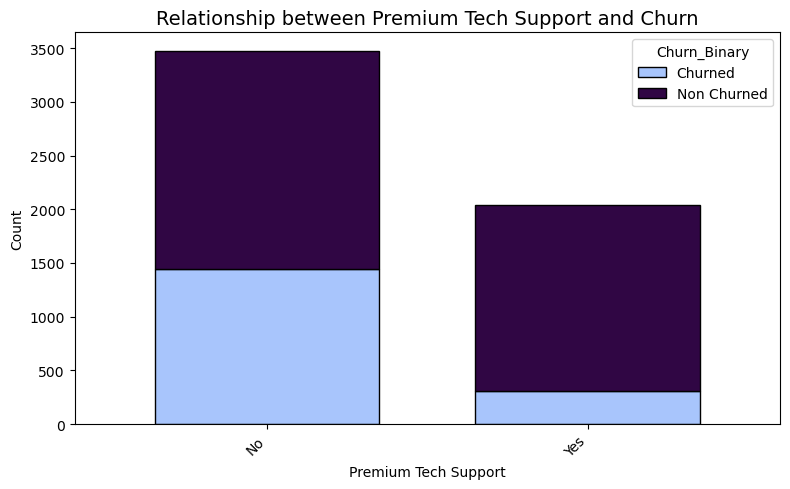

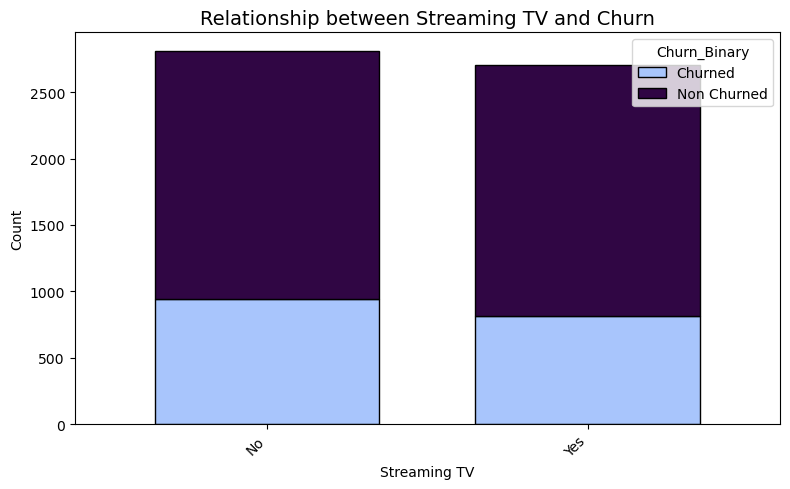

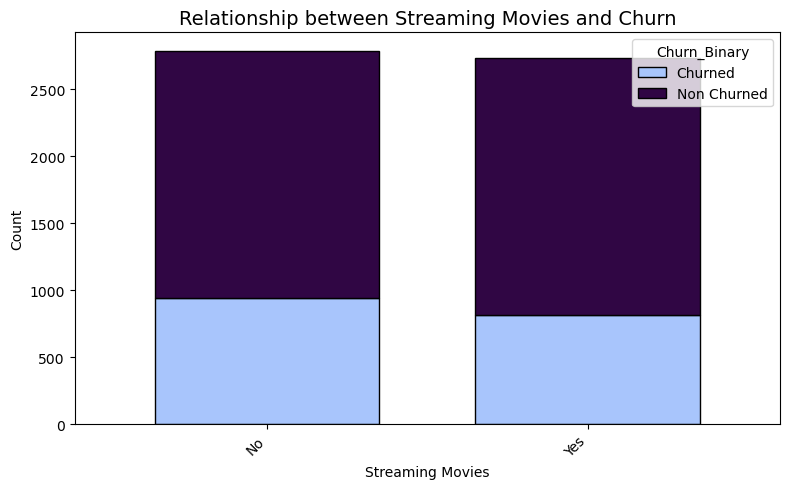

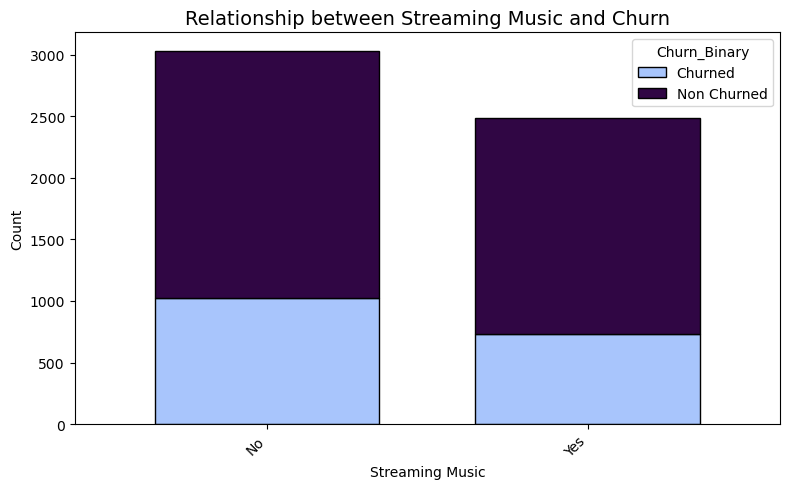

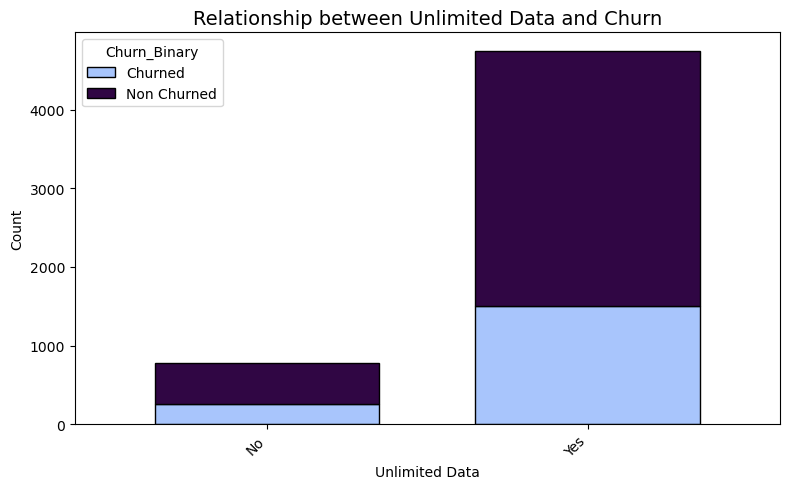

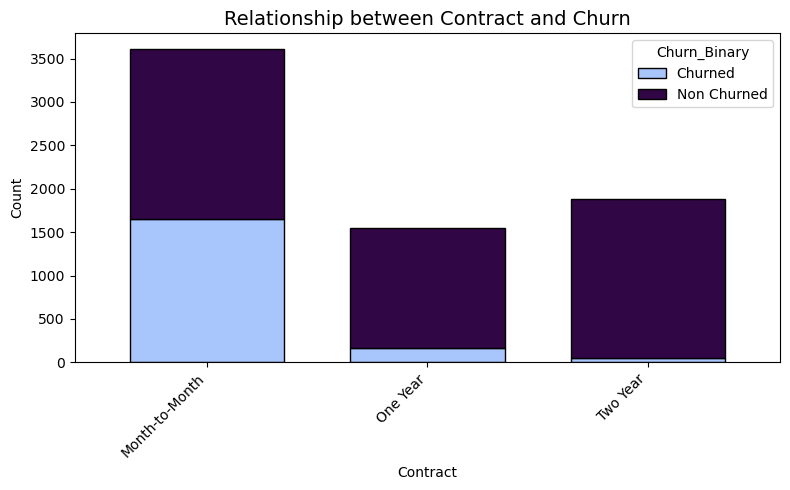

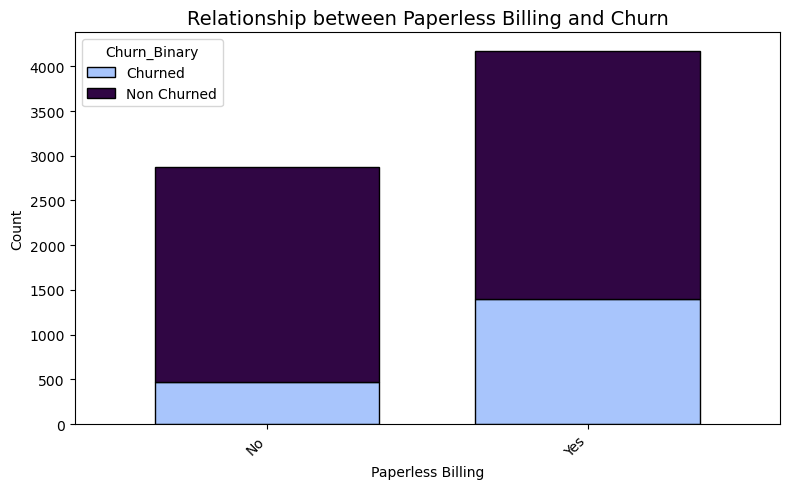

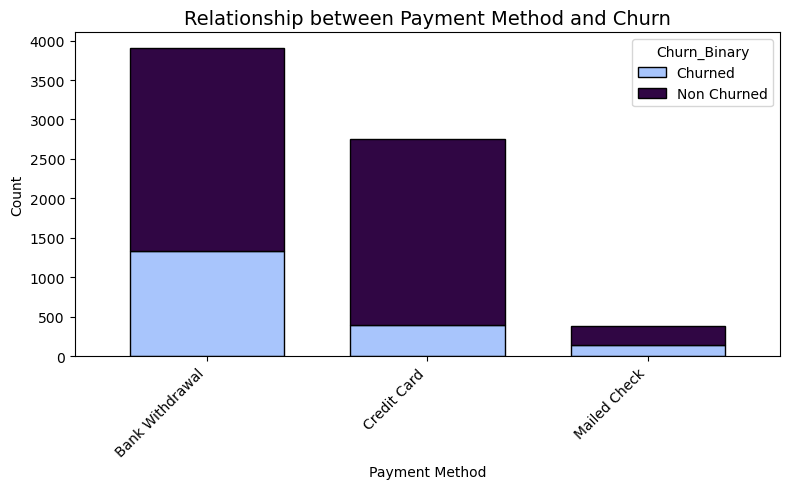

In [2003]:
quali_cols = vars_quali1.drop(['Customer Status'], axis=1)

custom_colors = ['#a8c5fc','#300644'] 
for col_name in quali_cols:

    feature_counts = data_churn.groupby([col_name, 'Churn_Binary']).size().unstack(fill_value=0)
    
    ax = feature_counts.plot(
        kind='bar',
        stacked=True,
        figsize=(8, 5),
        edgecolor='black',
        width=0.7,
        color=custom_colors  
    )

    plt.title(f'Relationship between {col_name} and Churn', fontsize=14)
    plt.xlabel(col_name)
    plt.ylabel('Count')
    plt.legend(title='Churn_Binary')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

### Traitement données manquantes

<Axes: >

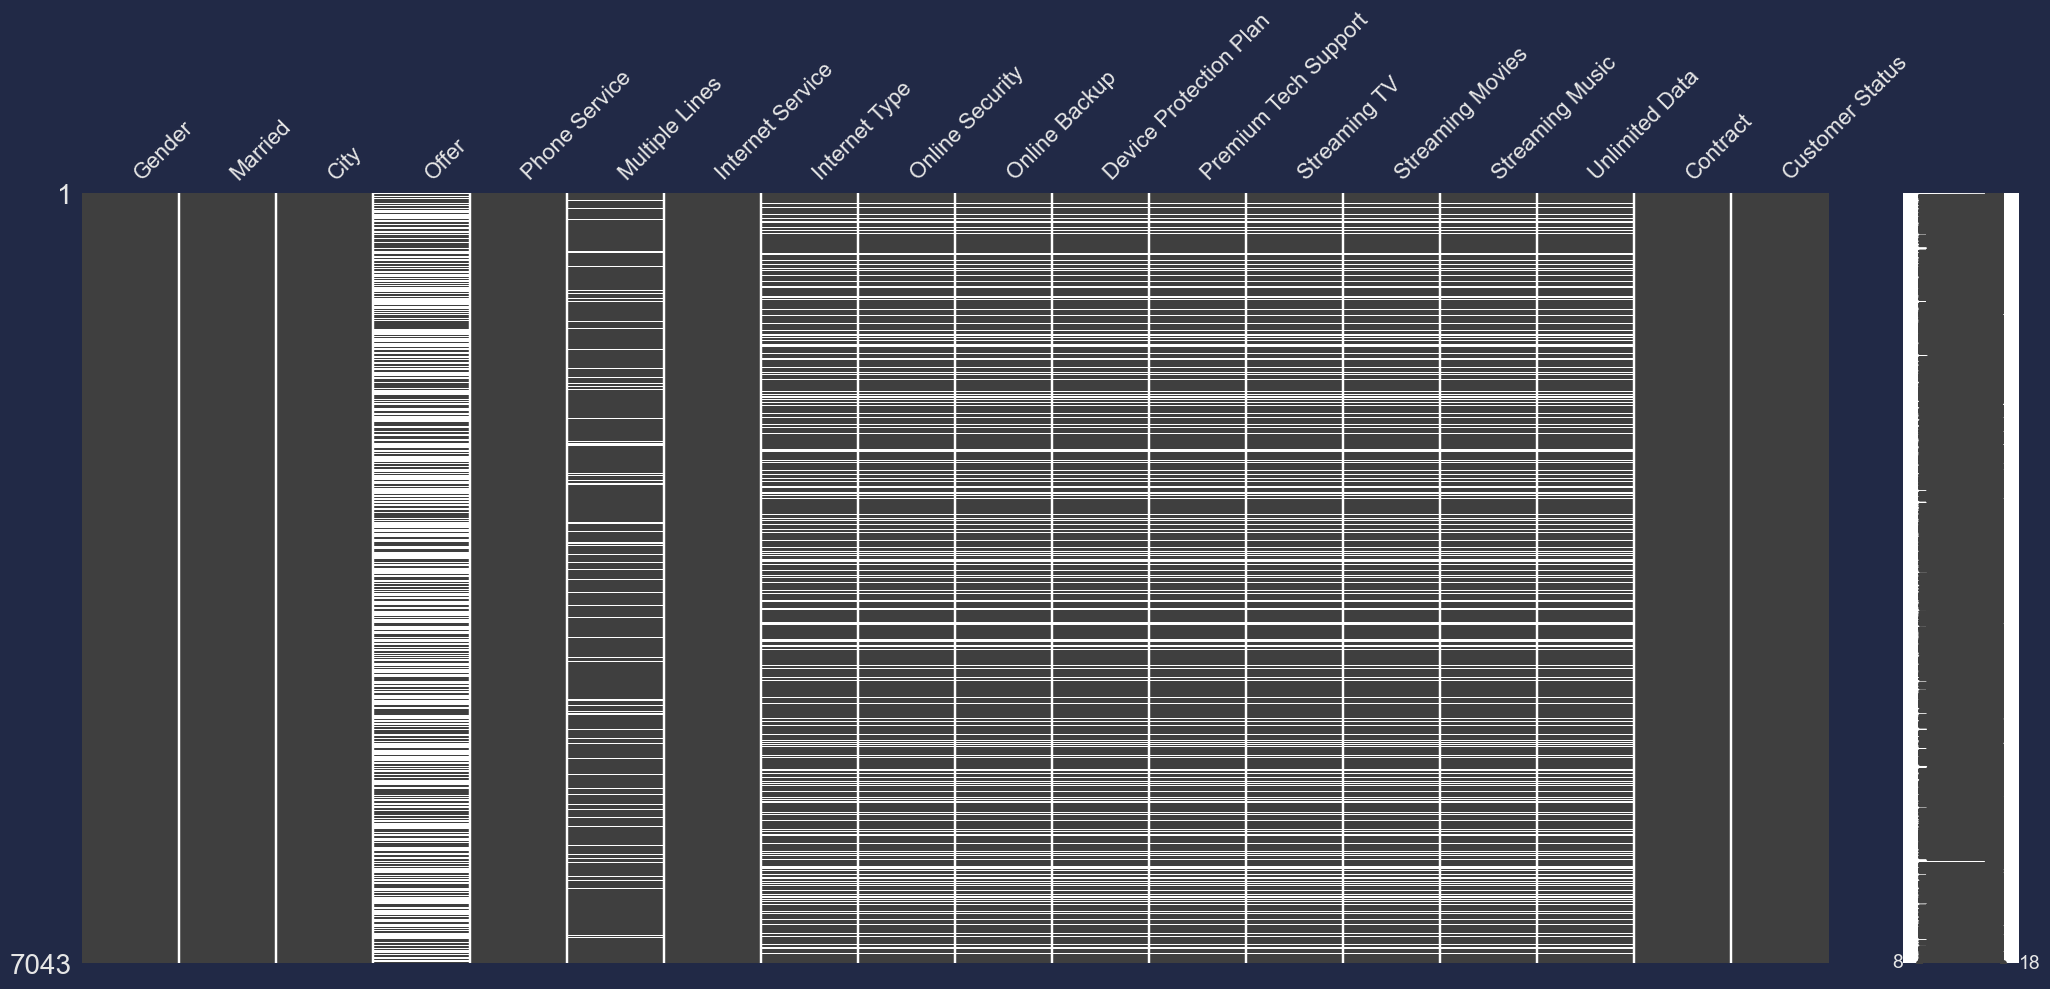

In [1639]:
msno.matrix(vars_quali)

<div style="background-color:#021740; padding:8px; border-style: solid; font-family:'Comic Sans MS', cursive; color:#FFFFFF; font-size:100%; text-align:left;">
    <p>Le statut du service Internet indique si le client est abonné ou non au service Internet de l'entreprise, indiqué par "Oui" ou "Non".</p>
    <p>Le nombre total de clients abonnés aux services Internet est de <strong>5 517</strong>.</p>
    <p>Comme illustré dans la visualisation précédente, certaines fonctionnalités dépendent de l'abonnement au service Internet. En d'autres termes, ces fonctionnalités deviennent accessibles lorsque le client souscrit au service Internet. Ces fonctionnalités comprennent :</p>
    <ul style="text-align: left;">
        <li>Type d'Internet</li>
        <li>Sécurité en ligne</li>
        <li>Sauvegarde en ligne</li>
        <li>Plan de protection des appareils</li>
        <li>Assistance technique premium</li>
        <li>Streaming TV</li>
        <li>Streaming de films</li>
        <li>Streaming de musique</li>
        <li>Données illimitées</li>
    </ul>
    <p>Sur la base des constatations ci-dessus, il est évident que les clients non abonnés aux services Internet présentent des valeurs nulles pour les fonctionnalités mentionnées. Par conséquent, afin d'uniformiser ces variables pour l'analyse, les valeurs nulles de ces colonnes devraient être remplacées par "Non".</p>
</div>

### Une vérification

In [1864]:
colonnes_manquantes = vars_quali.columns[vars_quali.isnull().any()]
print("Colonnes avec données manquantes :")
print(colonnes_manquantes)
print(vars_quali[colonnes_manquantes].isnull().sum())

Colonnes avec données manquantes :
Index(['Offer', 'Multiple Lines', 'Internet Type', 'Online Security',
       'Online Backup', 'Device Protection Plan', 'Premium Tech Support',
       'Streaming TV', 'Streaming Movies', 'Streaming Music',
       'Unlimited Data'],
      dtype='object')
Offer                     3877
Multiple Lines             682
Internet Type             1526
Online Security           1526
Online Backup             1526
Device Protection Plan    1526
Premium Tech Support      1526
Streaming TV              1526
Streaming Movies          1526
Streaming Music           1526
Unlimited Data            1526
dtype: int64


###### Nous vérifions si les valeurs manquantes des variables liées à Phone Service ou Internet Service sont exclusivement dues à la modalité 'No' de ces variables.

In [1866]:
def detect_lien(data, var_principale, vars_liees):
    for var in vars_liees:
        print(f"--- Analyse pour {var} ---")
        mask_nan = data[var].isna()
        ligne_result = (data.loc[mask_nan, var_principale] == 'No')
        print(f"Nombre de False pour {var} : {(~ligne_result).sum()}\n")

In [1868]:
detect_lien(vars_quali, 'Phone Service', ['Multiple Lines'])

--- Analyse pour Multiple Lines ---
Nombre de False pour Multiple Lines : 0



In [1870]:
vars_quali.loc[vars_quali["Phone Service"] == "No", "Multiple Lines"] = "No"

In [1872]:
# liste des variables qualitatives liées à internet
cols = [
    "Internet Type",
    "Online Security",
    "Online Backup",
    "Device Protection Plan",
    "Premium Tech Support",
    "Streaming TV",
    "Streaming Movies",
    "Streaming Music",
    "Unlimited Data"
]

In [1874]:
detect_lien(vars_quali, 'Internet Service', cols)

--- Analyse pour Internet Type ---
Nombre de False pour Internet Type : 0

--- Analyse pour Online Security ---
Nombre de False pour Online Security : 0

--- Analyse pour Online Backup ---
Nombre de False pour Online Backup : 0

--- Analyse pour Device Protection Plan ---
Nombre de False pour Device Protection Plan : 0

--- Analyse pour Premium Tech Support ---
Nombre de False pour Premium Tech Support : 0

--- Analyse pour Streaming TV ---
Nombre de False pour Streaming TV : 0

--- Analyse pour Streaming Movies ---
Nombre de False pour Streaming Movies : 0

--- Analyse pour Streaming Music ---
Nombre de False pour Streaming Music : 0

--- Analyse pour Unlimited Data ---
Nombre de False pour Unlimited Data : 0



In [1876]:
vars_quali[cols] = vars_quali[cols].fillna("No")

In [1880]:
vars_quali['Offer'] = vars_quali['Offer'].fillna('No')

<Axes: >

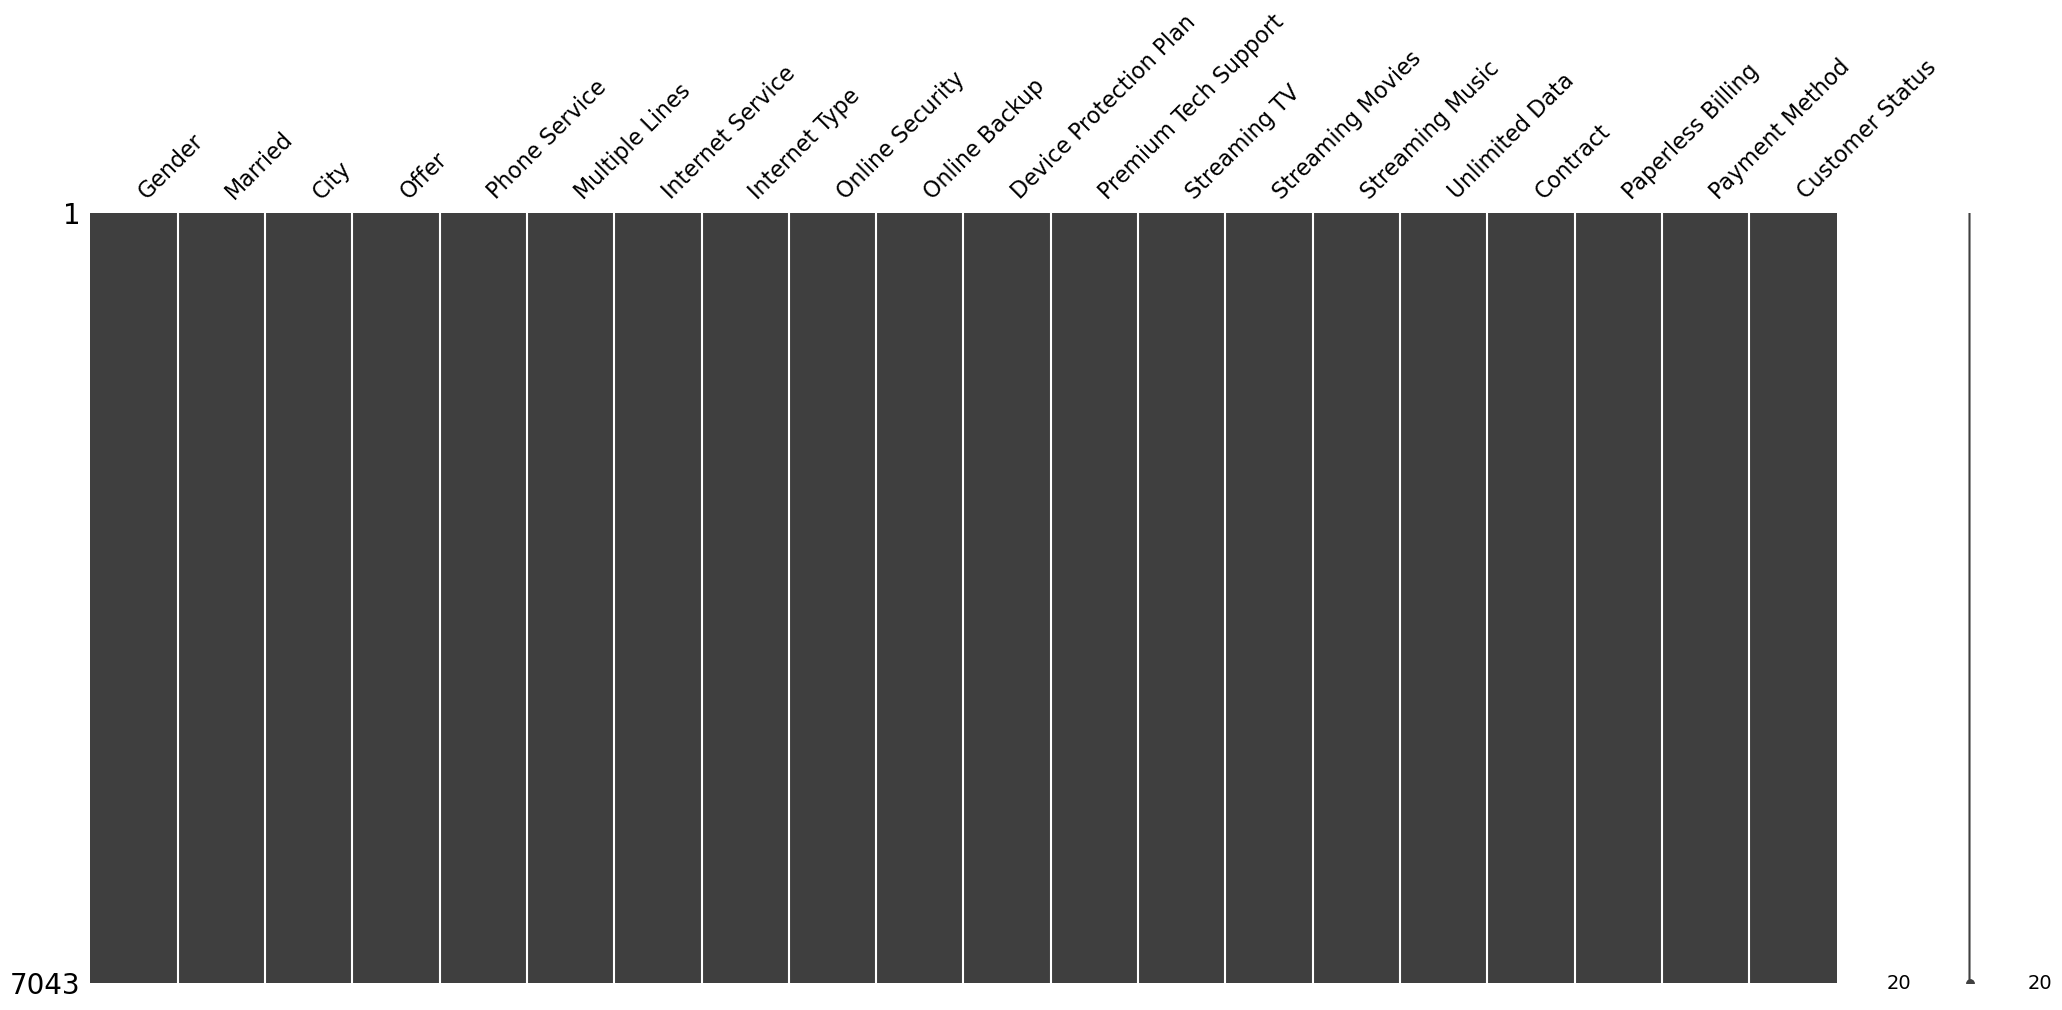

In [1995]:
msno.matrix(vars_quali)

# Variables quantitatives

In [1885]:
vars_quanti = data_churn.select_dtypes(include='number')
vars_quanti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                7043 non-null   int64  
 1   Number of Dependents               7043 non-null   int64  
 2   Zip Code                           7043 non-null   int64  
 3   Latitude                           7043 non-null   float64
 4   Longitude                          7043 non-null   float64
 5   Number of Referrals                7043 non-null   int64  
 6   Tenure in Months                   7043 non-null   int64  
 7   Avg Monthly Long Distance Charges  6361 non-null   float64
 8   Avg Monthly GB Download            5517 non-null   float64
 9   Monthly Charge                     7043 non-null   float64
 10  Total Charges                      7043 non-null   float64
 11  Total Refunds                      7043 non-null   float

In [1887]:
vars_quanti.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,7043.0,46.509726,16.750352,19.000000,32.000000,46.000000,60.000000,80.000000
Number of Dependents,7043.0,0.468692,0.962802,0.000000,0.000000,0.000000,0.000000,9.000000
Zip Code,7043.0,93486.070567,1856.767505,90001.000000,92101.000000,93518.000000,95329.000000,96150.000000
Latitude,7043.0,36.197455,2.468929,32.555828,33.990646,36.205465,38.161321,41.962127
Longitude,7043.0,-119.756684,2.154425,-124.301372,-121.788090,-119.595293,-117.969795,-114.192901
Number of Referrals,7043.0,1.951867,3.001199,0.000000,0.000000,0.000000,3.000000,11.000000
Tenure in Months,7043.0,32.386767,24.542061,1.000000,9.000000,29.000000,55.000000,72.000000
Avg Monthly Long Distance Charges,6361.0,25.420517,14.200374,1.010000,13.050000,25.690000,37.680000,49.990000
Avg Monthly GB Download,5517.0,26.189958,19.586585,2.000000,13.000000,21.000000,30.000000,85.000000
Monthly Charge,7043.0,63.596131,31.204743,-10.000000,30.400000,70.050000,89.750000,118.750000


###### La variable Monthly Charge présente des valeurs négatives (minimum = -10), ce qui est incohérent dans un contexte de facturation. Pour corriger cette anomalie, nous recalculerons cette variable comme suit : Monthly Charge = Total Charges / Tenure in Months

#### Visualisation graphique

In [1665]:
vars_quanti.columns

Index(['Age', 'Number of Dependents', 'Latitude', 'Longitude',
       'Number of Referrals', 'Tenure in Months',
       'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
       'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue'],
      dtype='object')

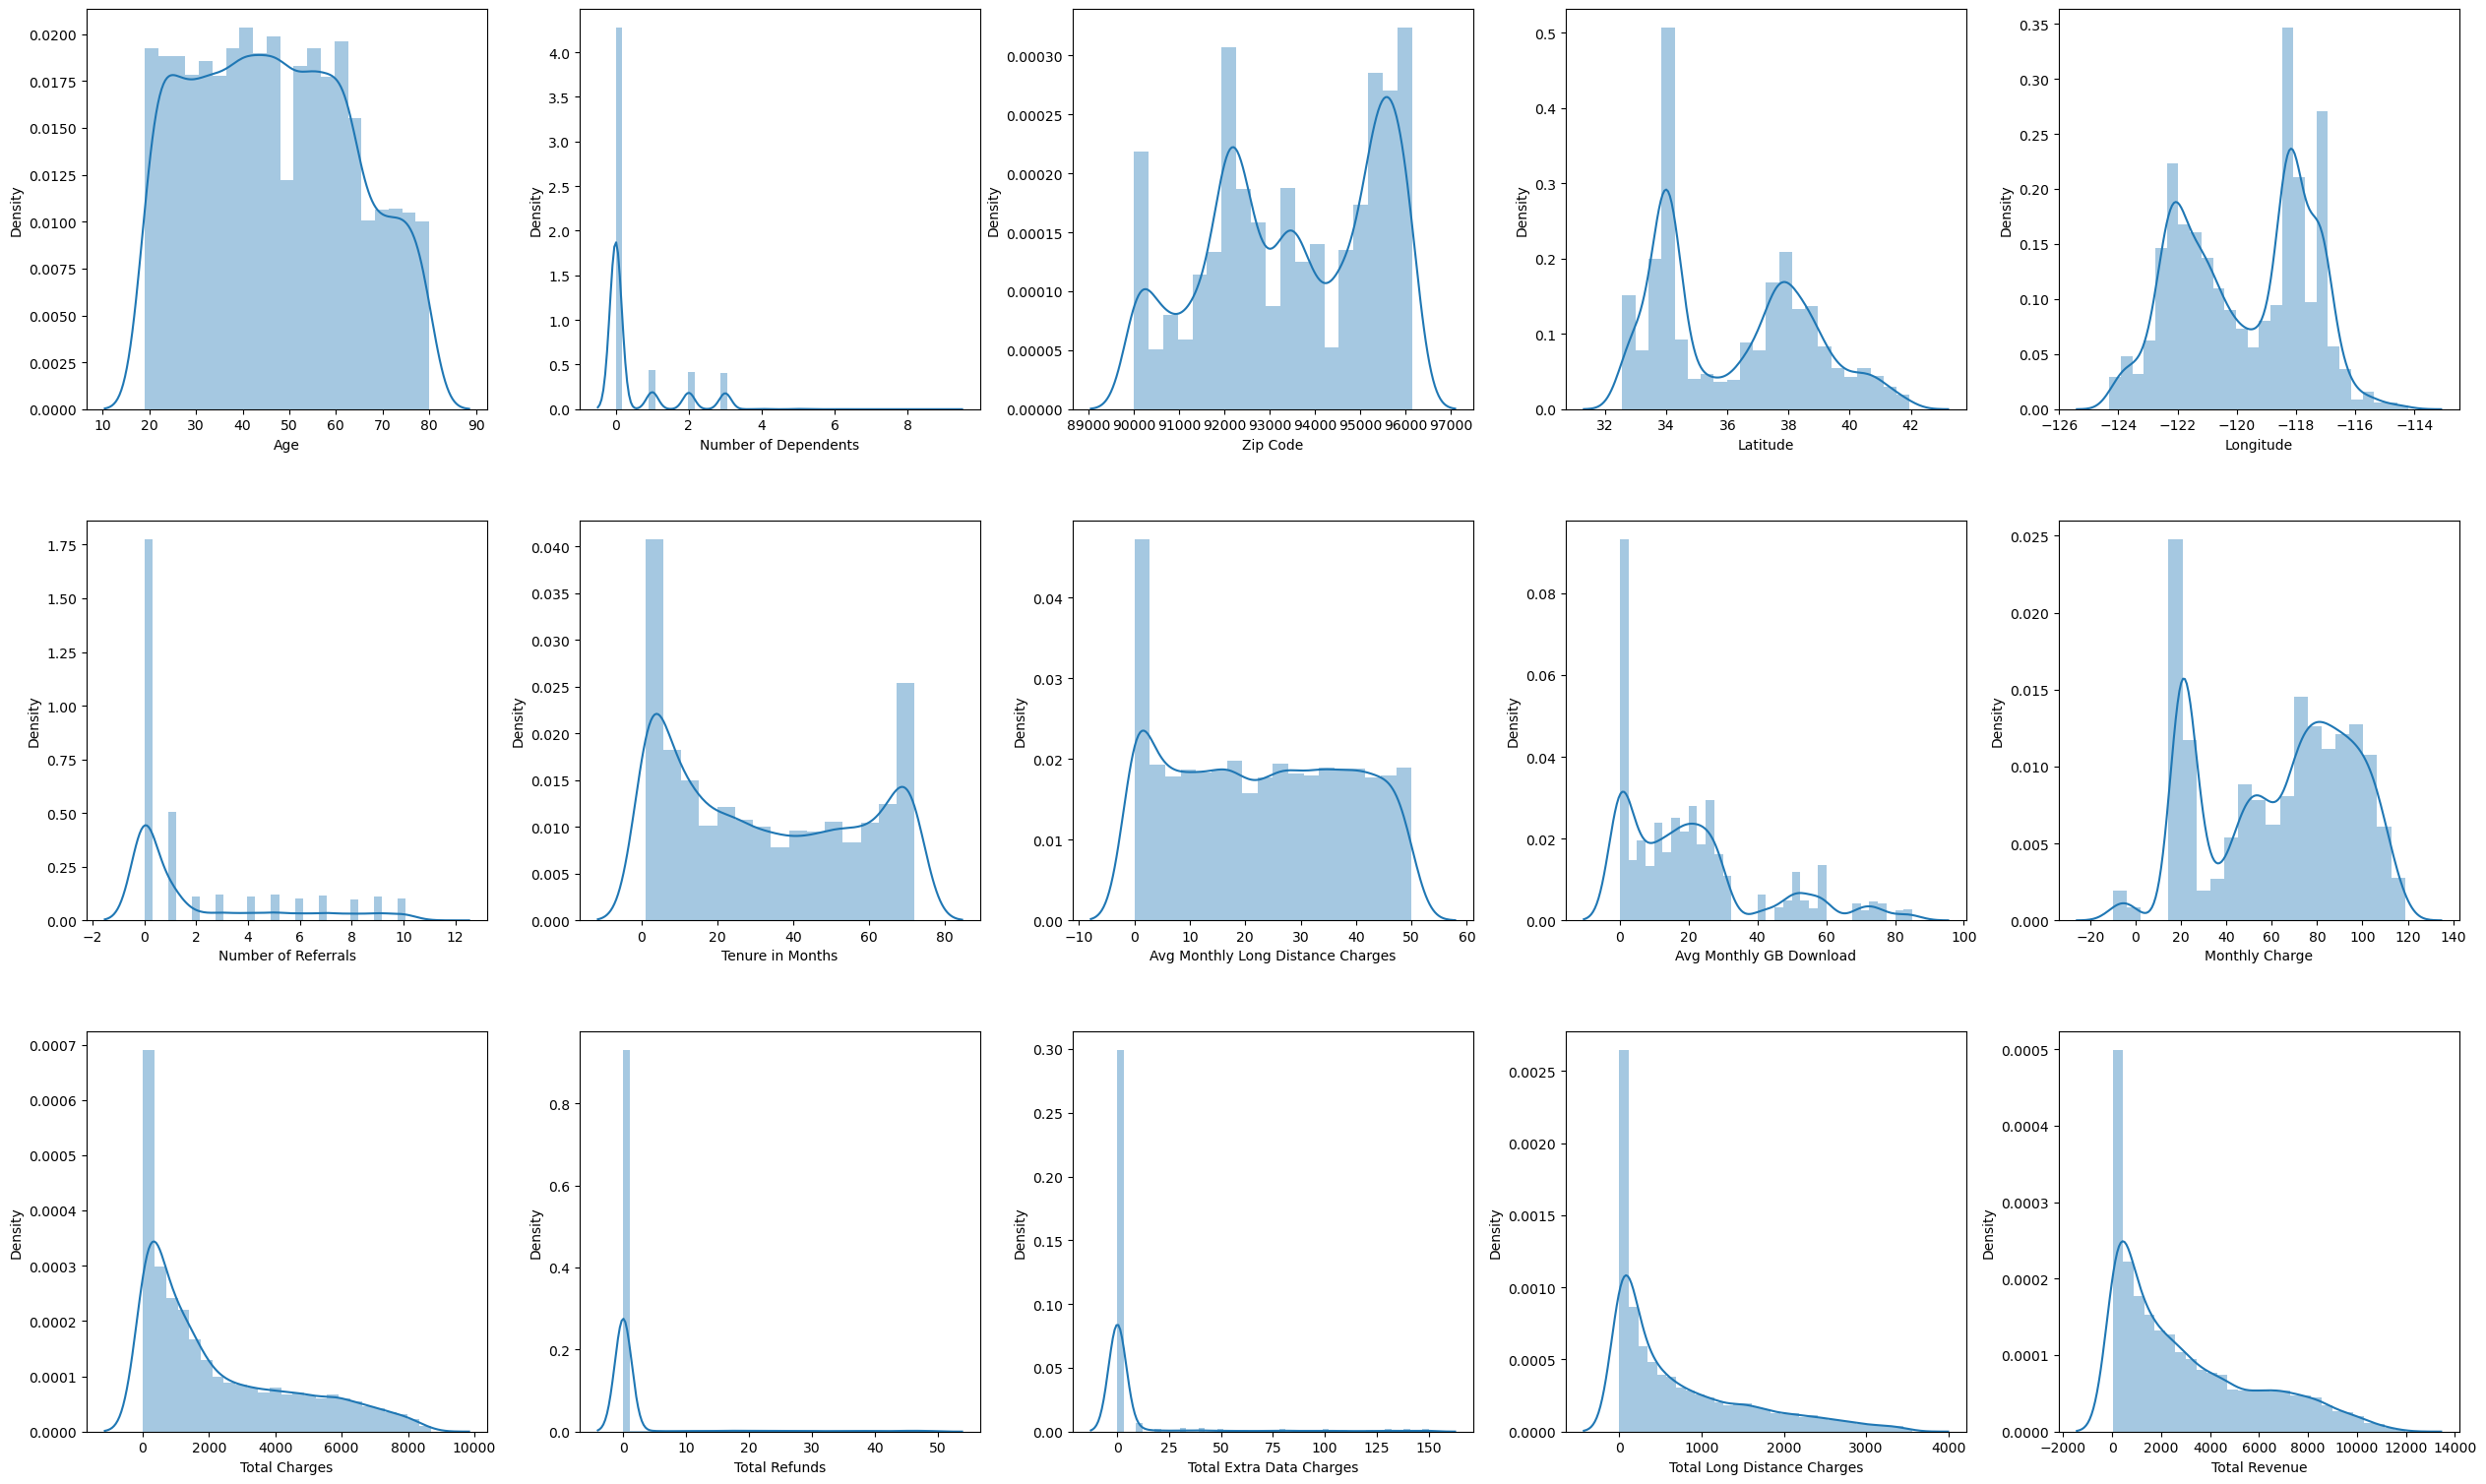

In [1993]:
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(25,15))
index = 0
axs = axs.flatten()
for k, v in vars_quanti.items():
  sns.distplot(v, ax=axs[index])
  index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5)

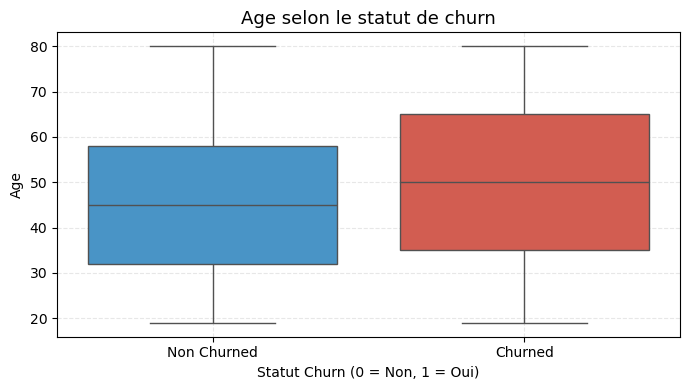

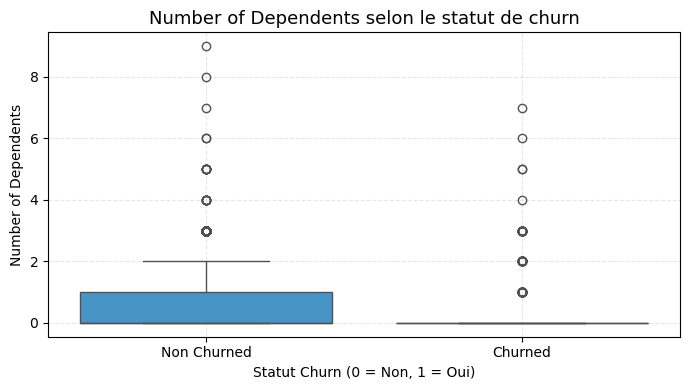

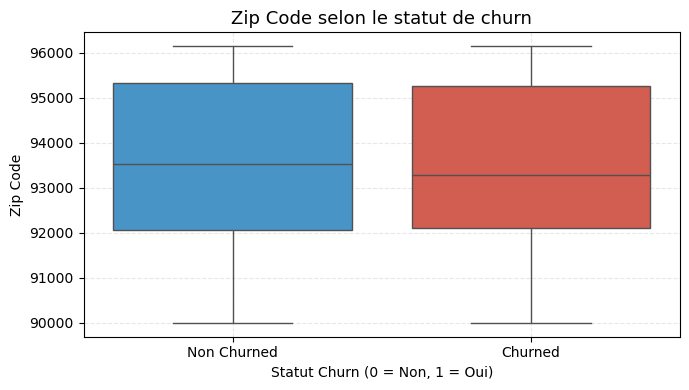

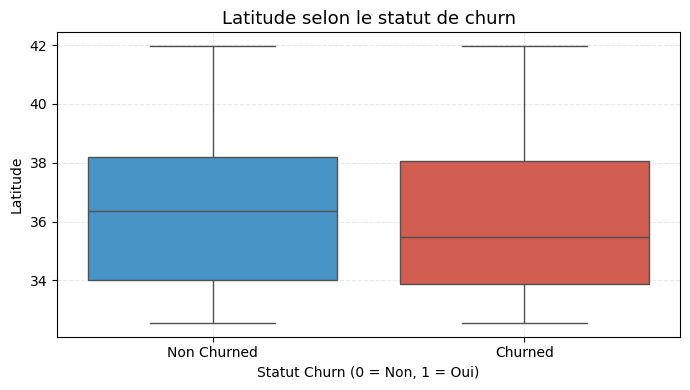

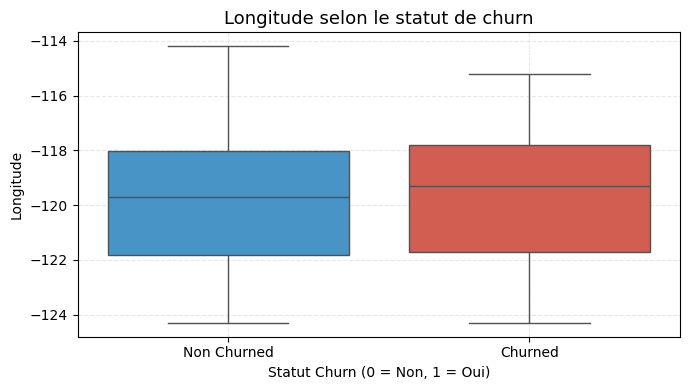

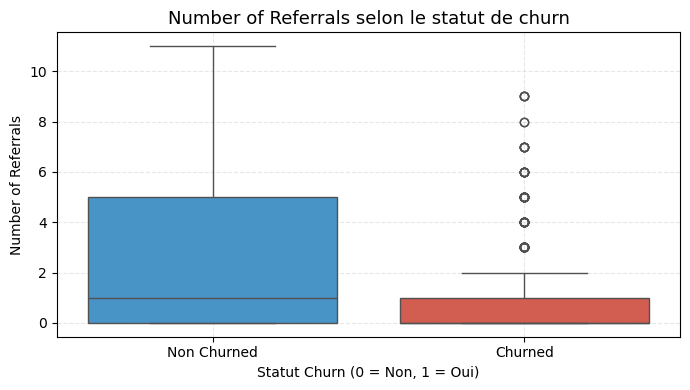

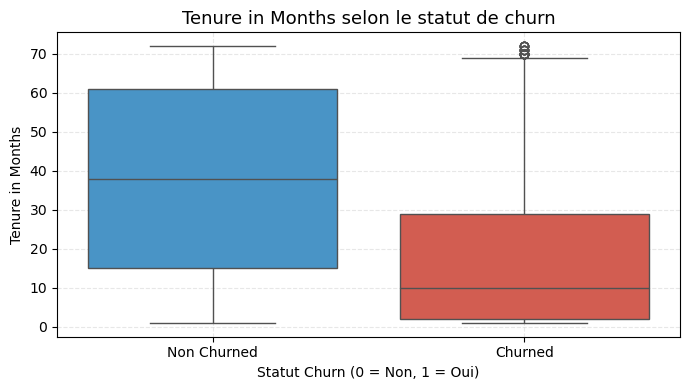

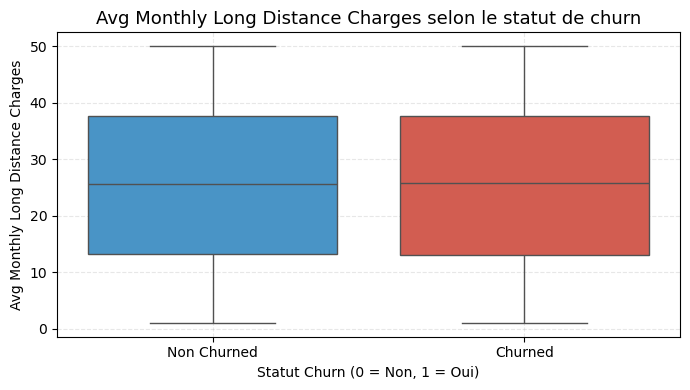

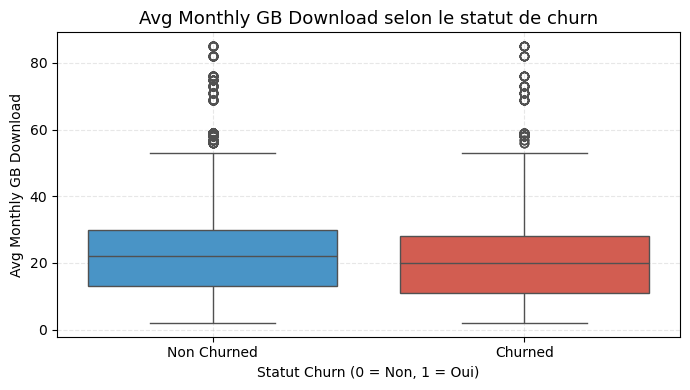

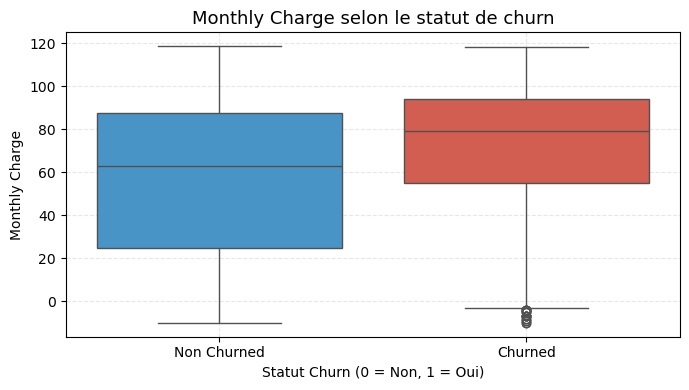

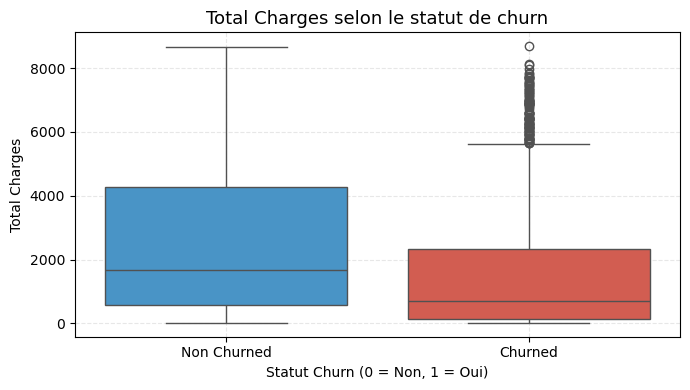

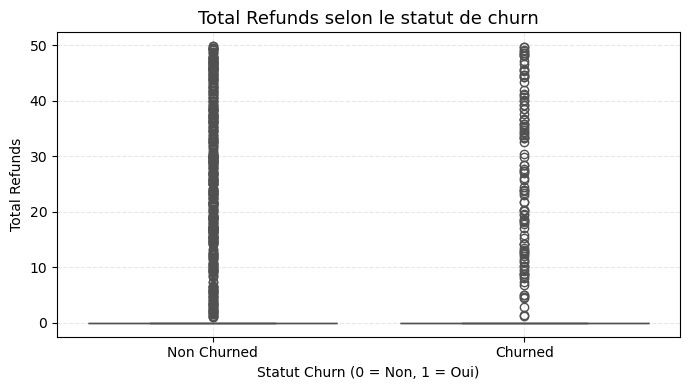

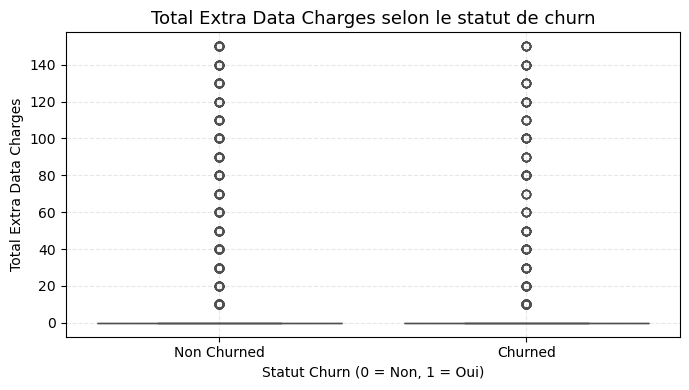

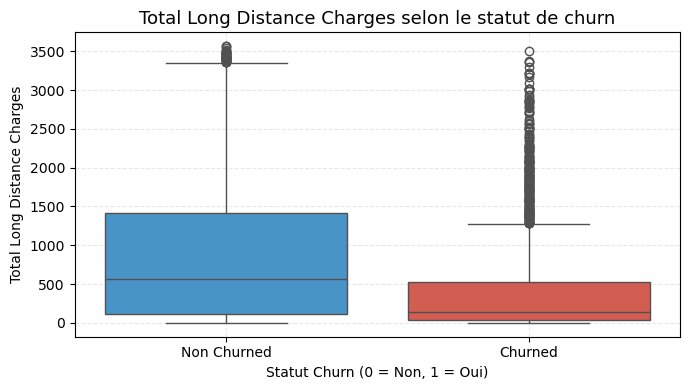

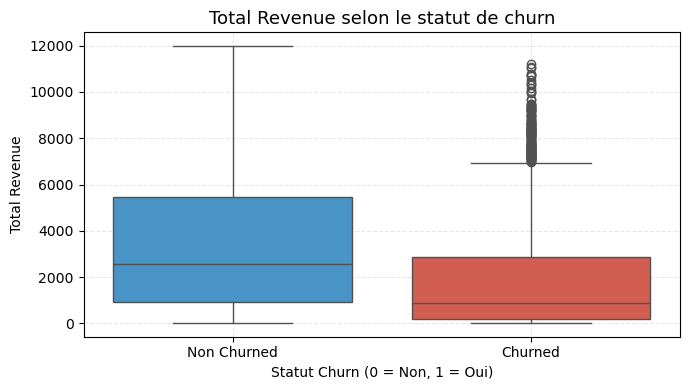

In [1991]:
palette = {
    'Non Churned': '#3498db',  
    'Churned': '#e74c3c'      
}

for col in vars_quanti:
    plt.figure(figsize=(7, 4))
    
    sns.boxplot(x='Churn_Binary', y=col, data=data_churn, palette=palette)
    
    plt.title(f'{col} selon le statut de churn', fontsize=13)
    plt.xlabel('Statut Churn (0 = Non, 1 = Oui)')
    plt.ylabel(col)
    
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Traitement données manquantes

<Axes: >

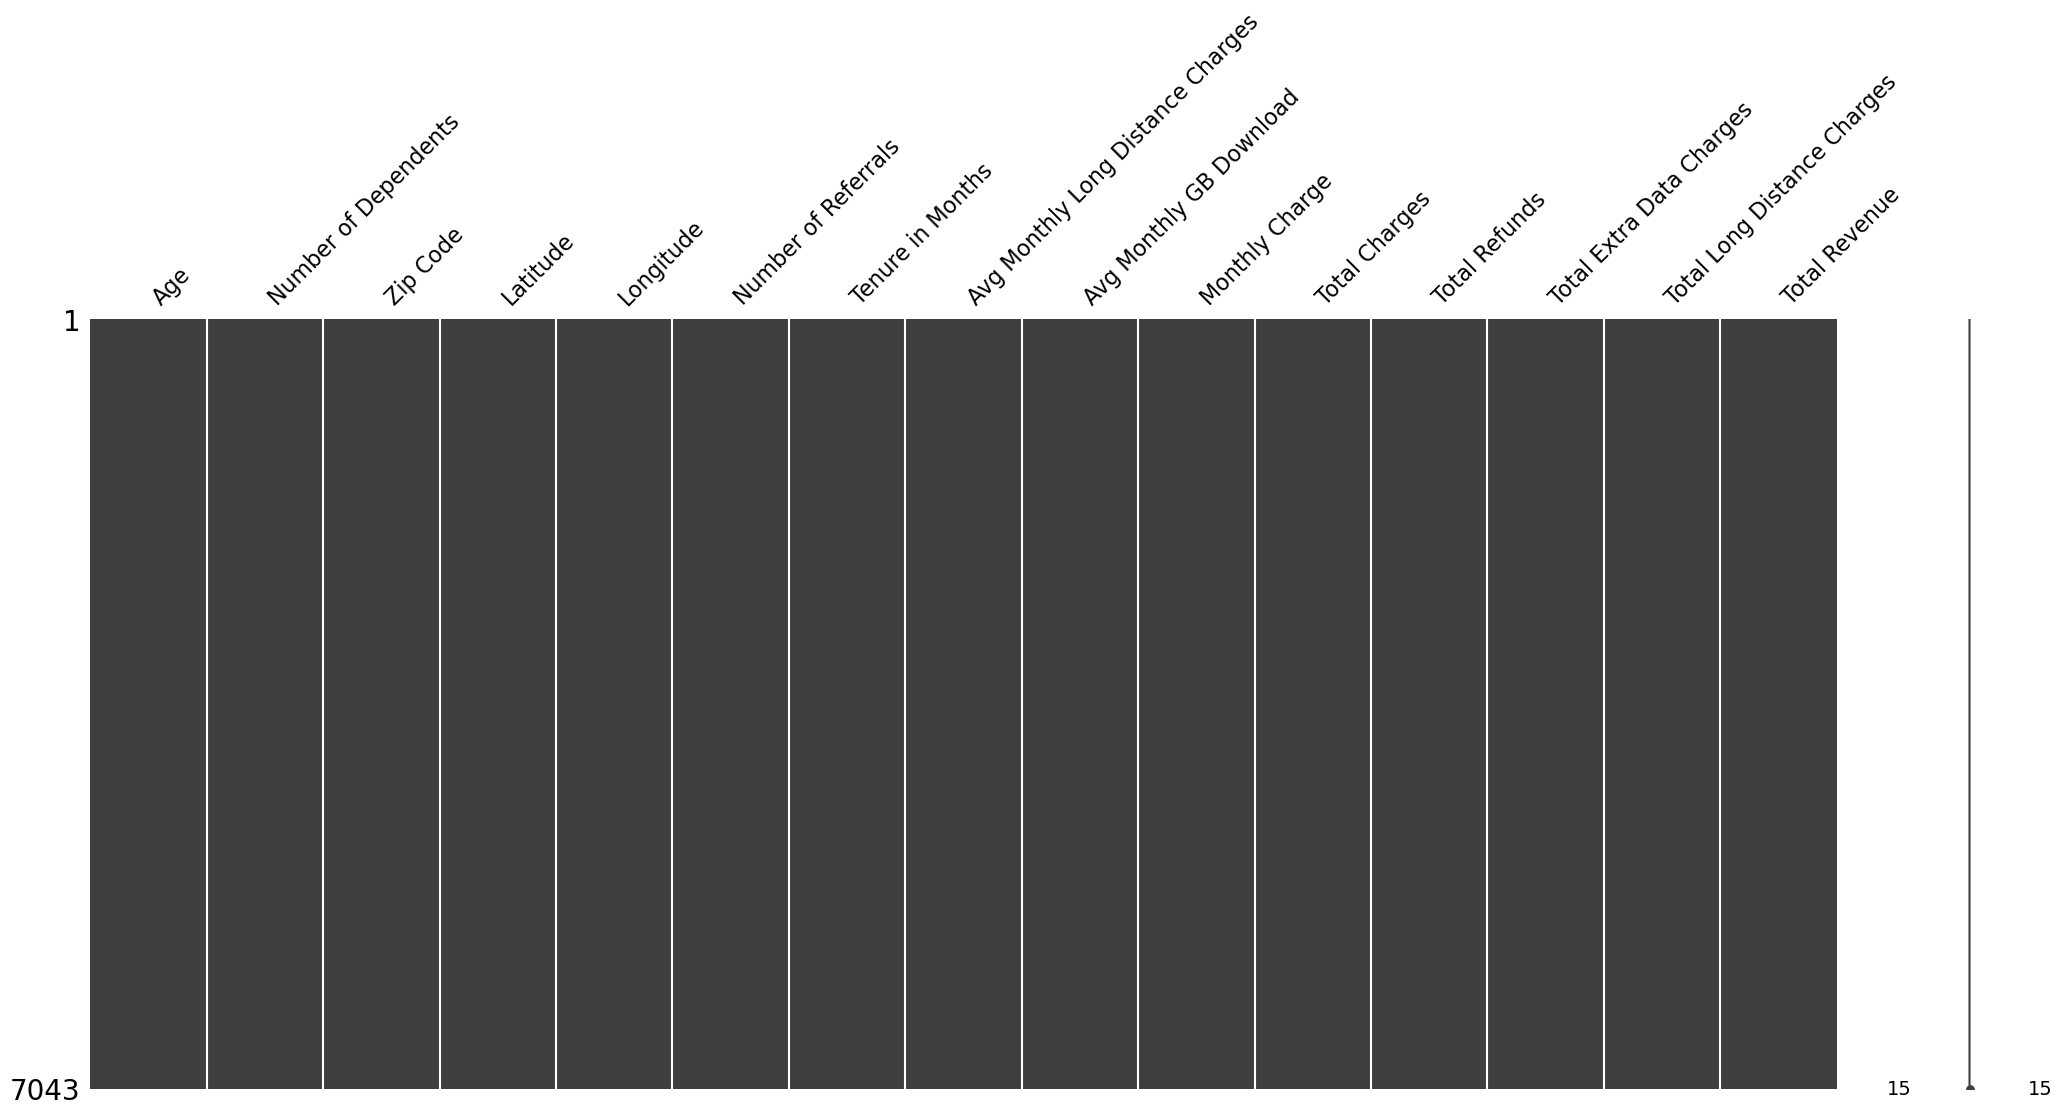

In [1986]:
plt.style.use('default')
msno.matrix(vars_quanti)

In [1912]:
colonnes_manquantes = vars_quanti.columns[vars_quanti.isnull().any()]
print("Colonnes avec données manquantes :")
print(colonnes_manquantes)

Colonnes avec données manquantes :
Index(['Avg Monthly Long Distance Charges', 'Avg Monthly GB Download'], dtype='object')


In [1914]:
detect_lien(data_churn, 'Phone Service', ['Avg Monthly Long Distance Charges'])

--- Analyse pour Avg Monthly Long Distance Charges ---
Nombre de False pour Avg Monthly Long Distance Charges : 0



In [1916]:
vars_quanti['Avg Monthly Long Distance Charges'] = vars_quanti['Avg Monthly Long Distance Charges'].fillna(0)

In [1918]:
detect_lien(data_churn, 'Internet Service', ['Avg Monthly GB Download'])

--- Analyse pour Avg Monthly GB Download ---
Nombre de False pour Avg Monthly GB Download : 0



In [1982]:
vars_quanti['Avg Monthly GB Download'] = vars_quanti['Avg Monthly GB Download'].fillna(0)

<Axes: >

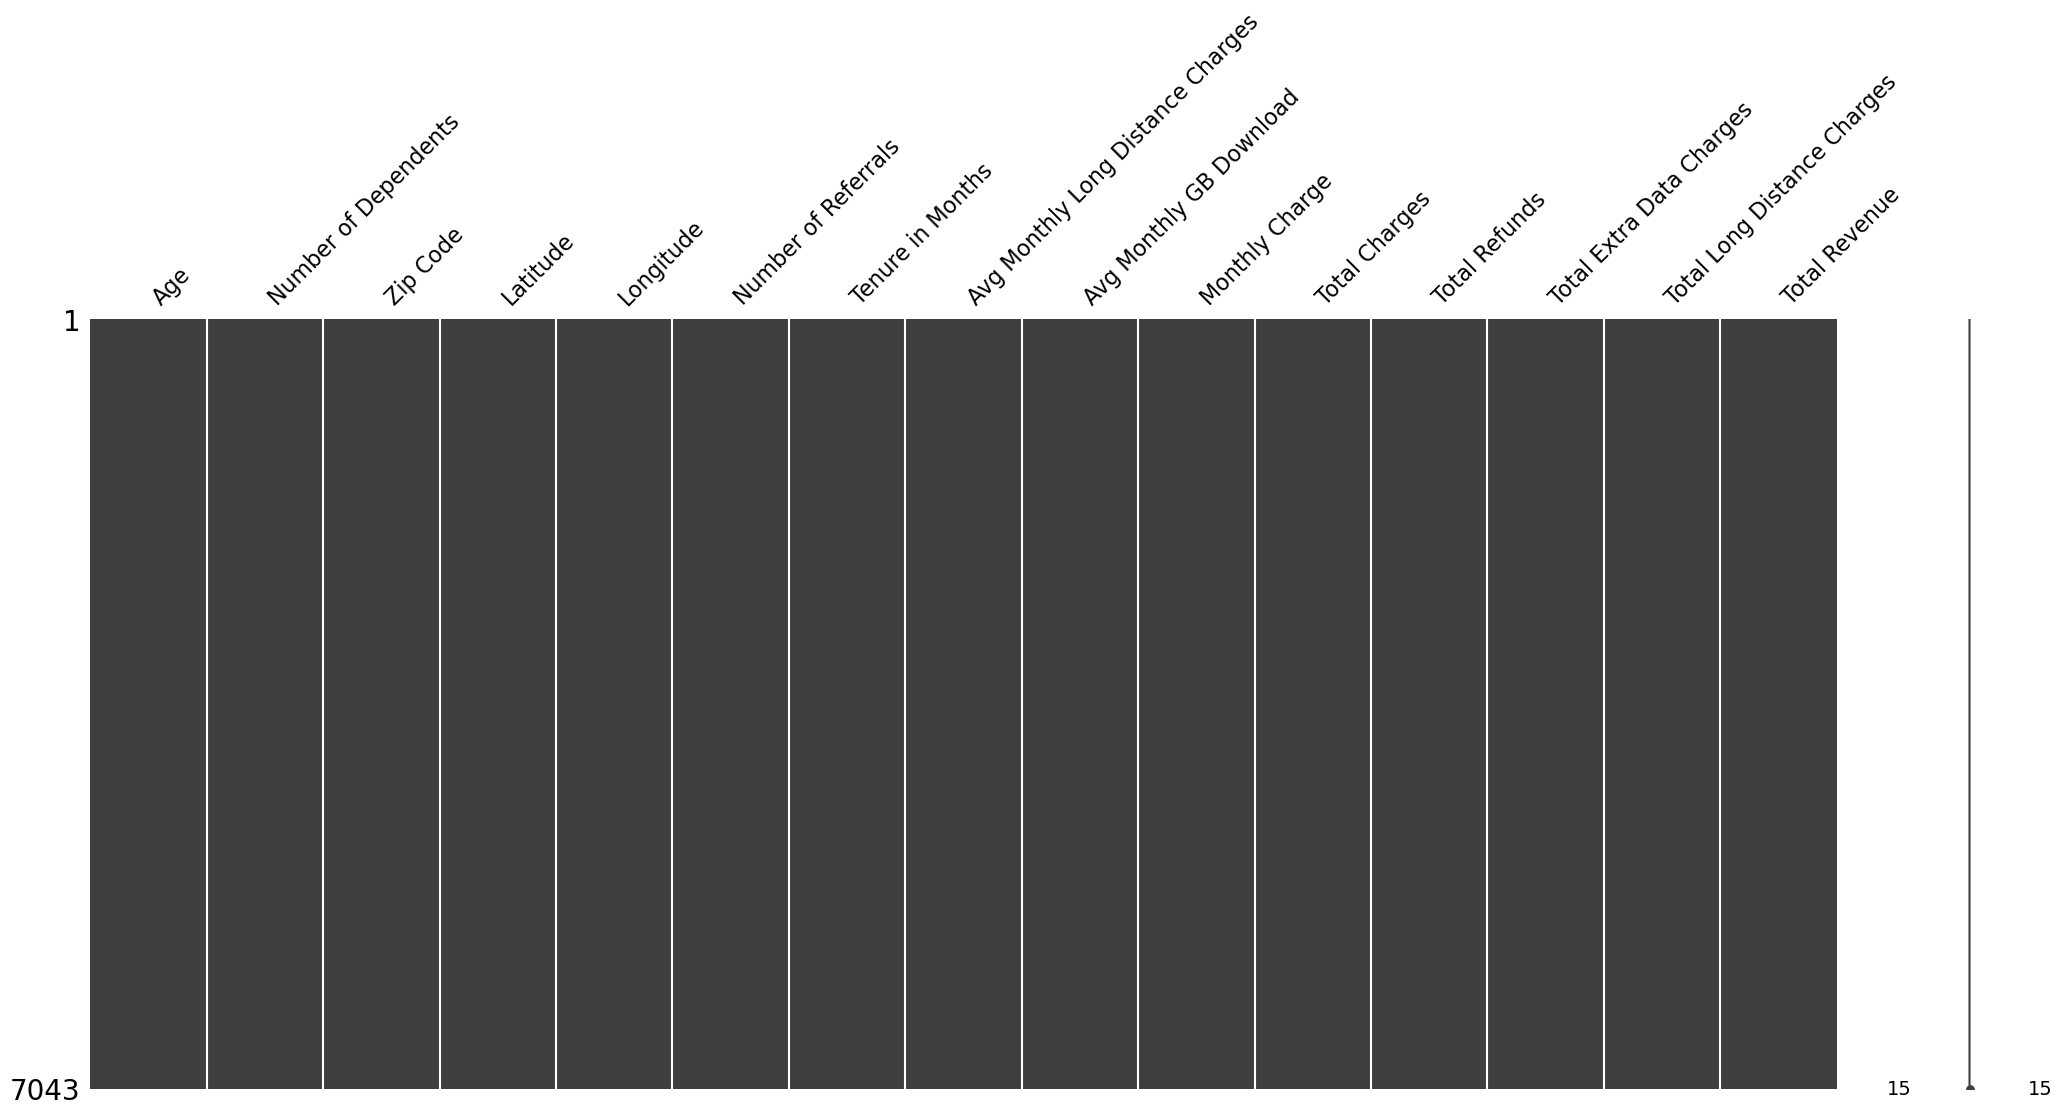

In [1984]:
plt.style.use('default')
msno.matrix(vars_quanti)

In [1922]:
data_clean =pd.concat([vars_quali, vars_quanti], axis=1)

In [1924]:
data_clean.shape

(7043, 35)

# Variables synthétiques

In [1929]:
internet_services = [
    'Online Security', 'Online Backup', 'Device Protection Plan',
    'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 
    'Streaming Music', 'Unlimited Data'
]

In [1931]:
# Compteur total des services Internet
data_clean['Internet_Services_Count'] = data_clean[internet_services].apply(
    lambda row: sum(1 for val in row if val == 'Yes'), axis=1
)

In [1933]:
# Charges mensuels moyens
data_clean['Monthly_charge'] = data_clean['Total Charges'] / data_clean['Tenure in Months']

In [1935]:
# Revenus mensuels moyens
data_clean['Monthly_Revenue'] = data_clean['Total Revenue'] / data_clean['Tenure in Months']

In [1937]:
# Taux de remboursement
data_clean['Refund_Rate'] = np.where(data_clean['Total Charges'] > 0, 
                            data_clean['Total Refunds'] / data_clean['Total Charges'], 0)

In [1939]:
# Taux de charges supplémentaires
data_clean['Extra_Charges_Rate'] = np.where(data_clean['Total Charges'] > 0,
                                   (data_clean['Total Extra Data Charges'] + data_clean['Total Long Distance Charges']) / data_clean['Total Revenue'], 0)


In [1941]:
data_clean_export = pd.concat([data_clean, data_churn[['Churn Category', 'Churn Reason','City']]], axis=1)
data_clean_export.shape 

(7043, 43)

In [1945]:
data_clean_export.to_csv("data_clean_churn.csv", index=False)

In [1959]:
vars_supp= [ 'Online Security', 'Online Backup', 'Device Protection Plan',
    'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 
    'Streaming Music', 'Unlimited Data', 'Total Charges', 'Total Refunds', 'Total Revenue',
     'Total Extra Data Charges', 'Total Long Distance Charges', 'Monthly Charge',
            'Avg Monthly Long Distance Charges', 'Latitude', 'Longitude','Customer Status']

In [1961]:
data_reduis = data_clean.drop(columns=vars_supp)

In [1963]:
data_reduis.shape

(7043, 22)

In [1965]:
data_reduis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   7043 non-null   object 
 1   Married                  7043 non-null   object 
 2   City                     7043 non-null   object 
 3   Offer                    7043 non-null   object 
 4   Phone Service            7043 non-null   object 
 5   Multiple Lines           7043 non-null   object 
 6   Internet Service         7043 non-null   object 
 7   Internet Type            7043 non-null   object 
 8   Contract                 7043 non-null   object 
 9   Paperless Billing        7043 non-null   object 
 10  Payment Method           7043 non-null   object 
 11  Age                      7043 non-null   int64  
 12  Number of Dependents     7043 non-null   int64  
 13  Zip Code                 7043 non-null   int64  
 14  Number of Referrals     

#### Vue des nouvelles variables créées

In [1967]:
new_vars_quanti = data_reduis.select_dtypes(include='number')
new_vars_quanti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      7043 non-null   int64  
 1   Number of Dependents     7043 non-null   int64  
 2   Zip Code                 7043 non-null   int64  
 3   Number of Referrals      7043 non-null   int64  
 4   Tenure in Months         7043 non-null   int64  
 5   Avg Monthly GB Download  7043 non-null   float64
 6   Internet_Services_Count  7043 non-null   int64  
 7   Monthly_charge           7043 non-null   float64
 8   Monthly_Revenue          7043 non-null   float64
 9   Refund_Rate              7043 non-null   float64
 10  Extra_Charges_Rate       7043 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 605.4 KB


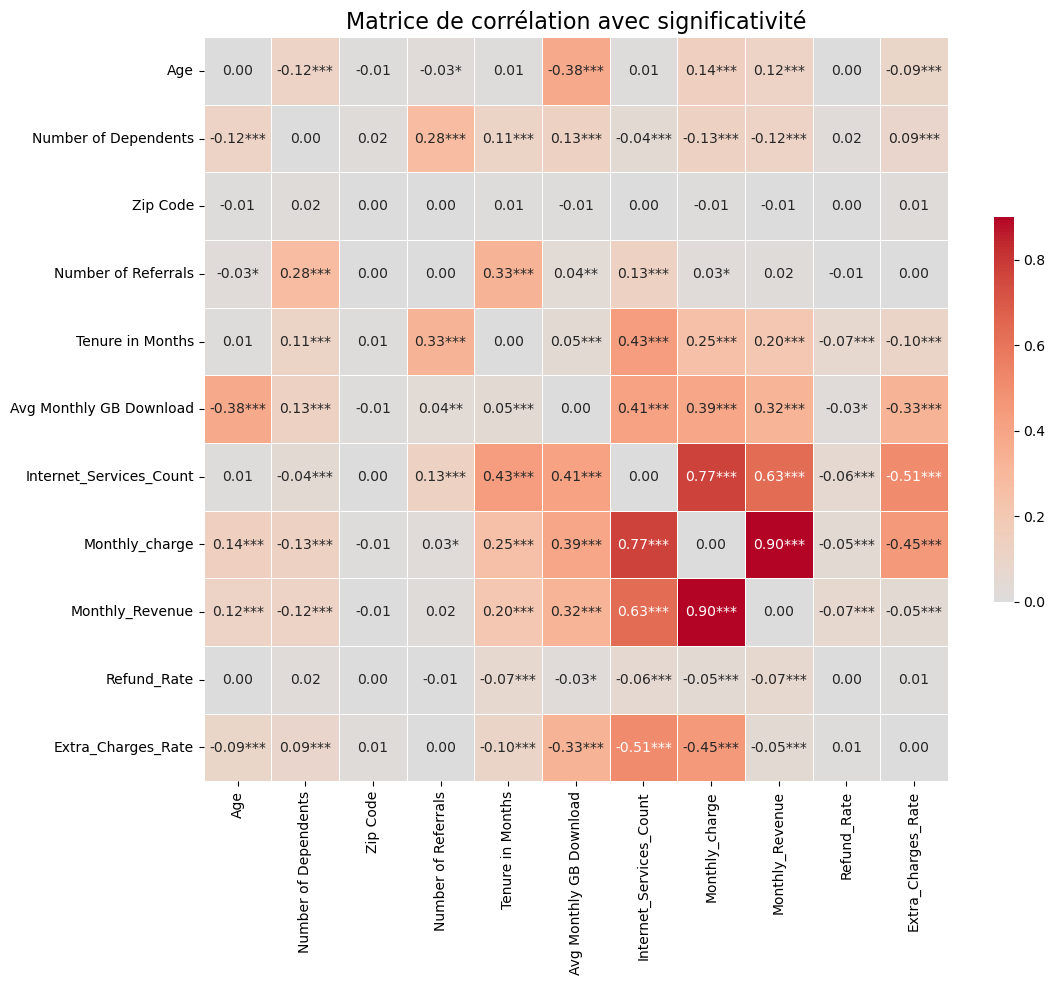

In [2005]:
corr = new_vars_quanti.corr()
pval = pd.DataFrame(np.ones(corr.shape), columns=corr.columns, index=corr.index)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        if i != j:
            r, p = pearsonr(new_vars_quanti.iloc[:, i], new_vars_quanti.iloc[:, j])
            corr.iloc[i, j] = r
            pval.iloc[i, j] = p
        else:
            corr.iloc[i, j] = 0
            pval.iloc[i, j] = 1
            
def corr_sig_annot(r, p):
    stars = ''
    if p < 0.001:
        stars = '***'
    elif p < 0.01:
        stars = '**'
    elif p < 0.05:
        stars = '*'
    return f'{r:.2f}{stars}'

annot = corr.copy()
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        annot.iloc[i, j] = corr_sig_annot(corr.iloc[i, j], pval.iloc[i, j])

plt.figure(figsize=(12, 10))
sns.heatmap(corr.abs(), annot=annot, fmt='', cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Matrice de corrélation avec significativité", fontsize=16)
plt.show()

##### On supprime "Monthly_charge" très corrélé à 3 autres variables

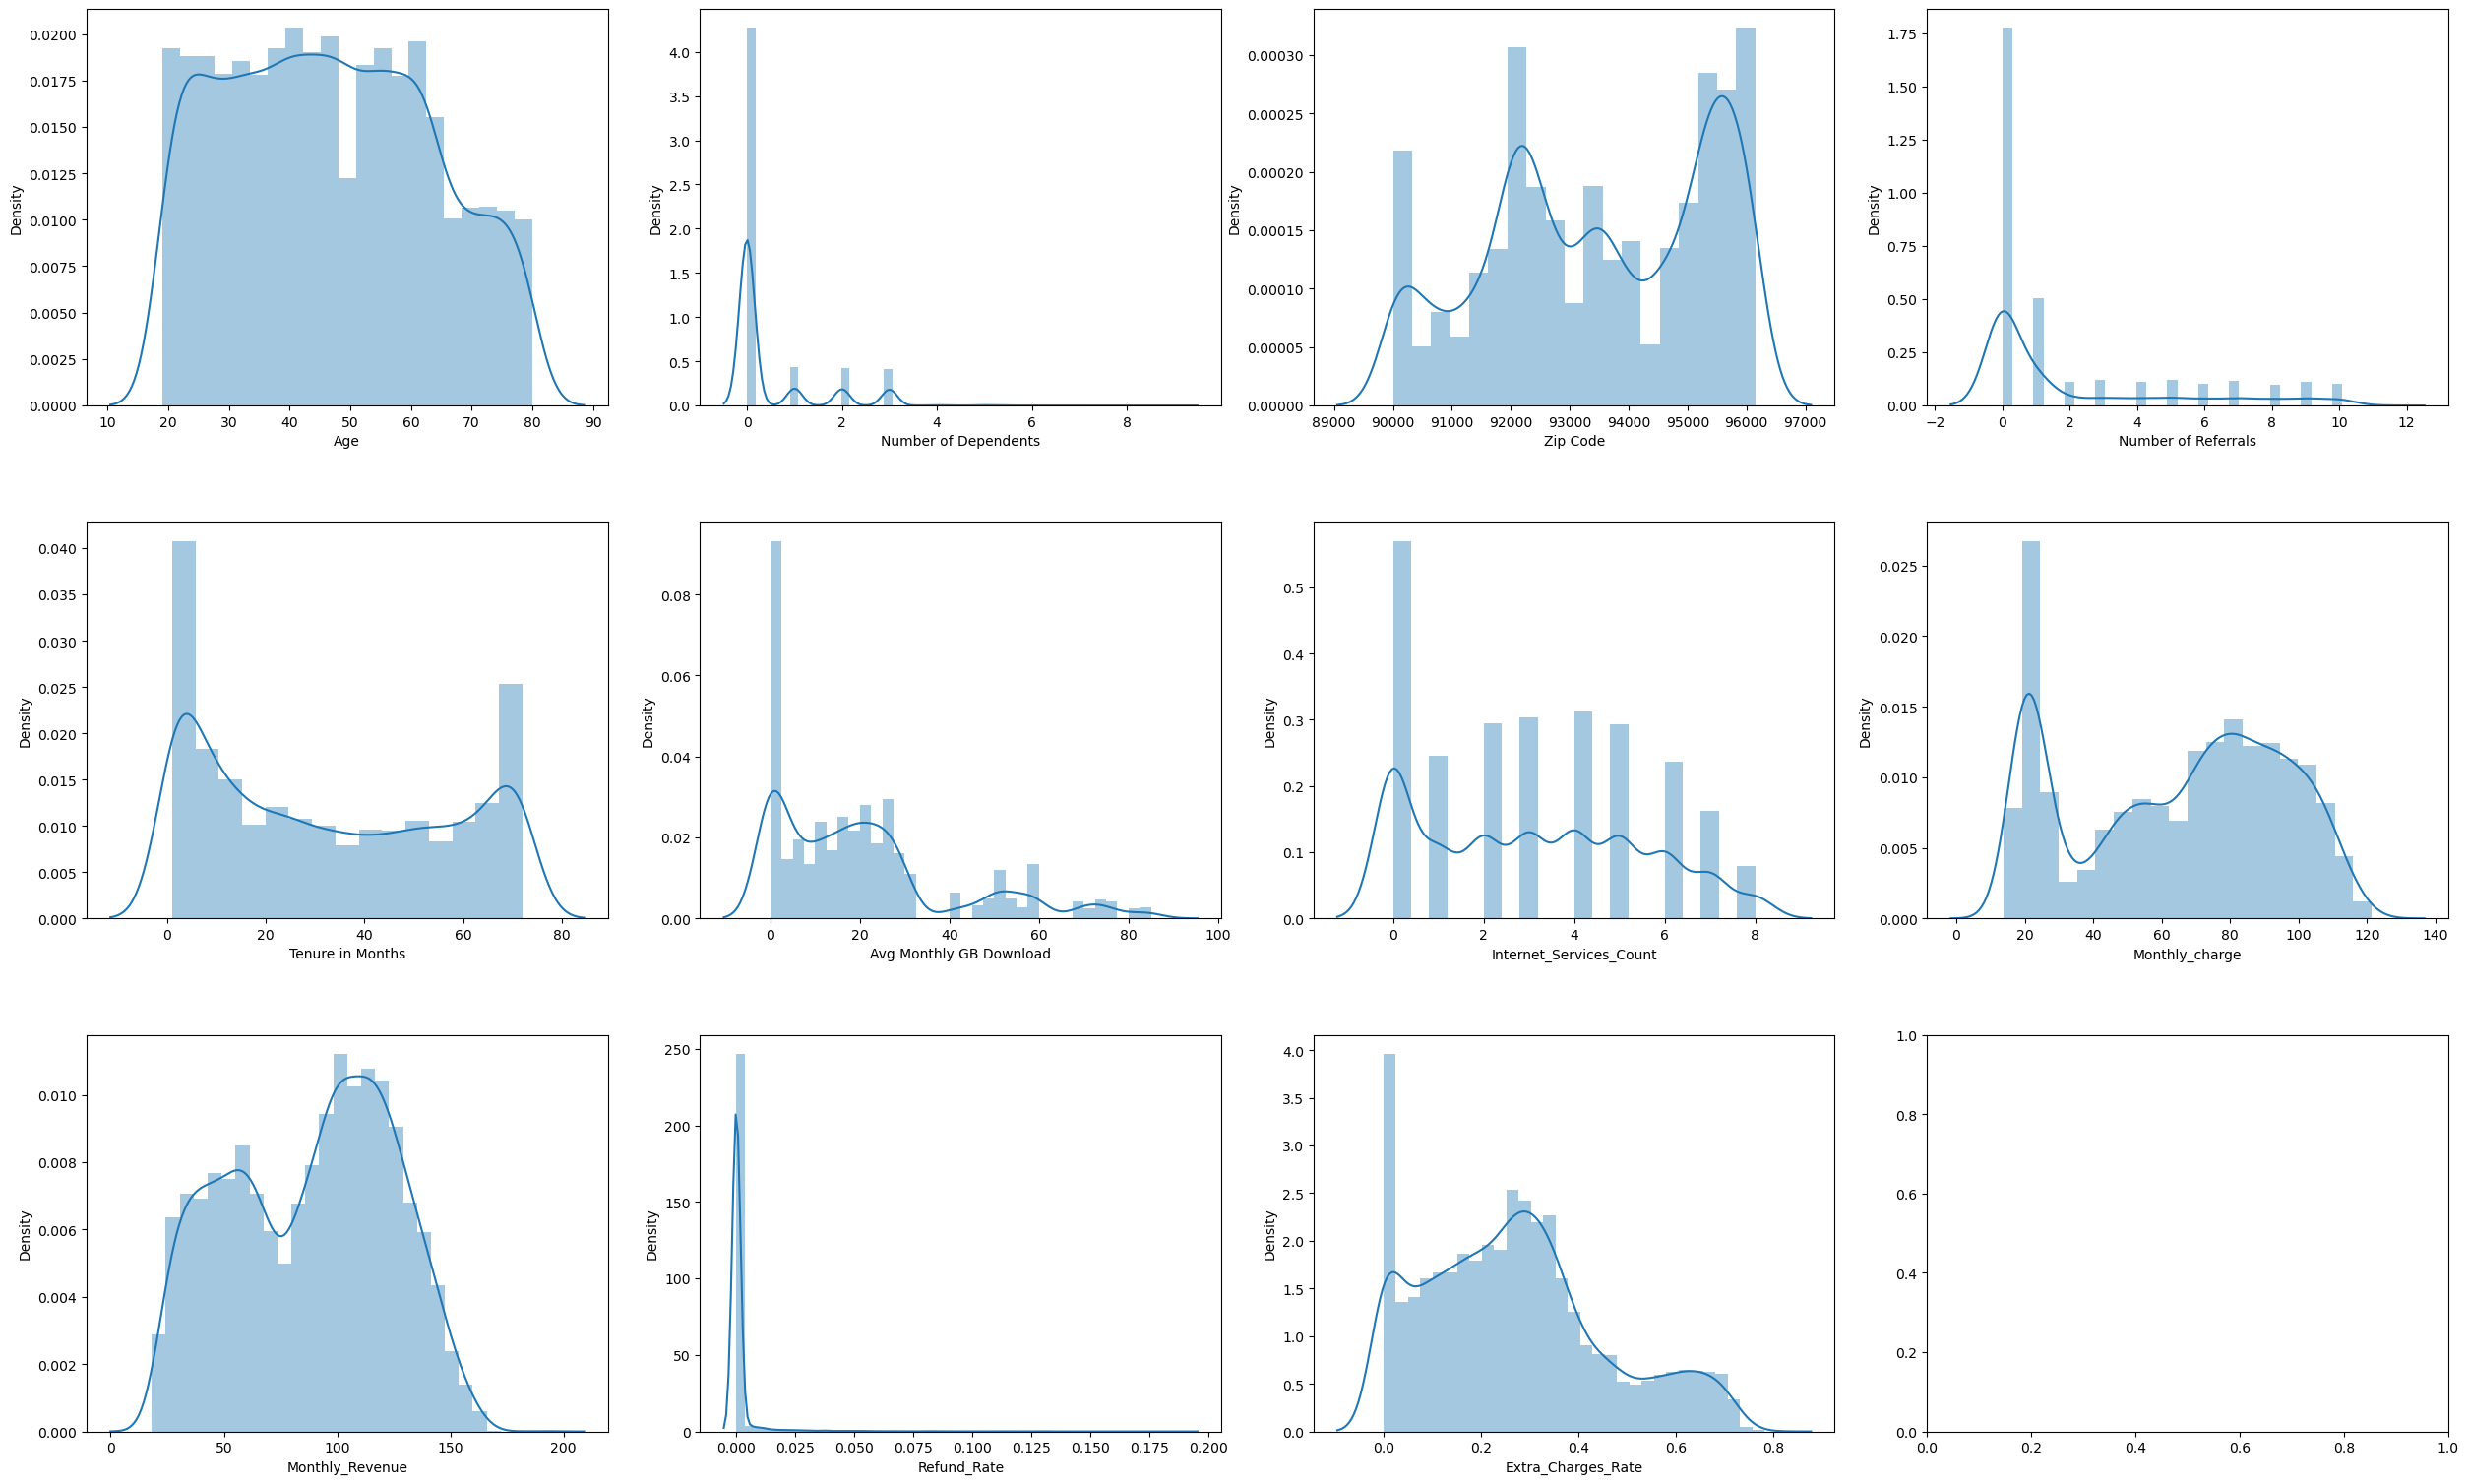

In [2007]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(25,15))
index = 0
axs = axs.flatten()
for k, v in new_vars_quanti.items():
  sns.distplot(v, ax=axs[index])
  index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5)

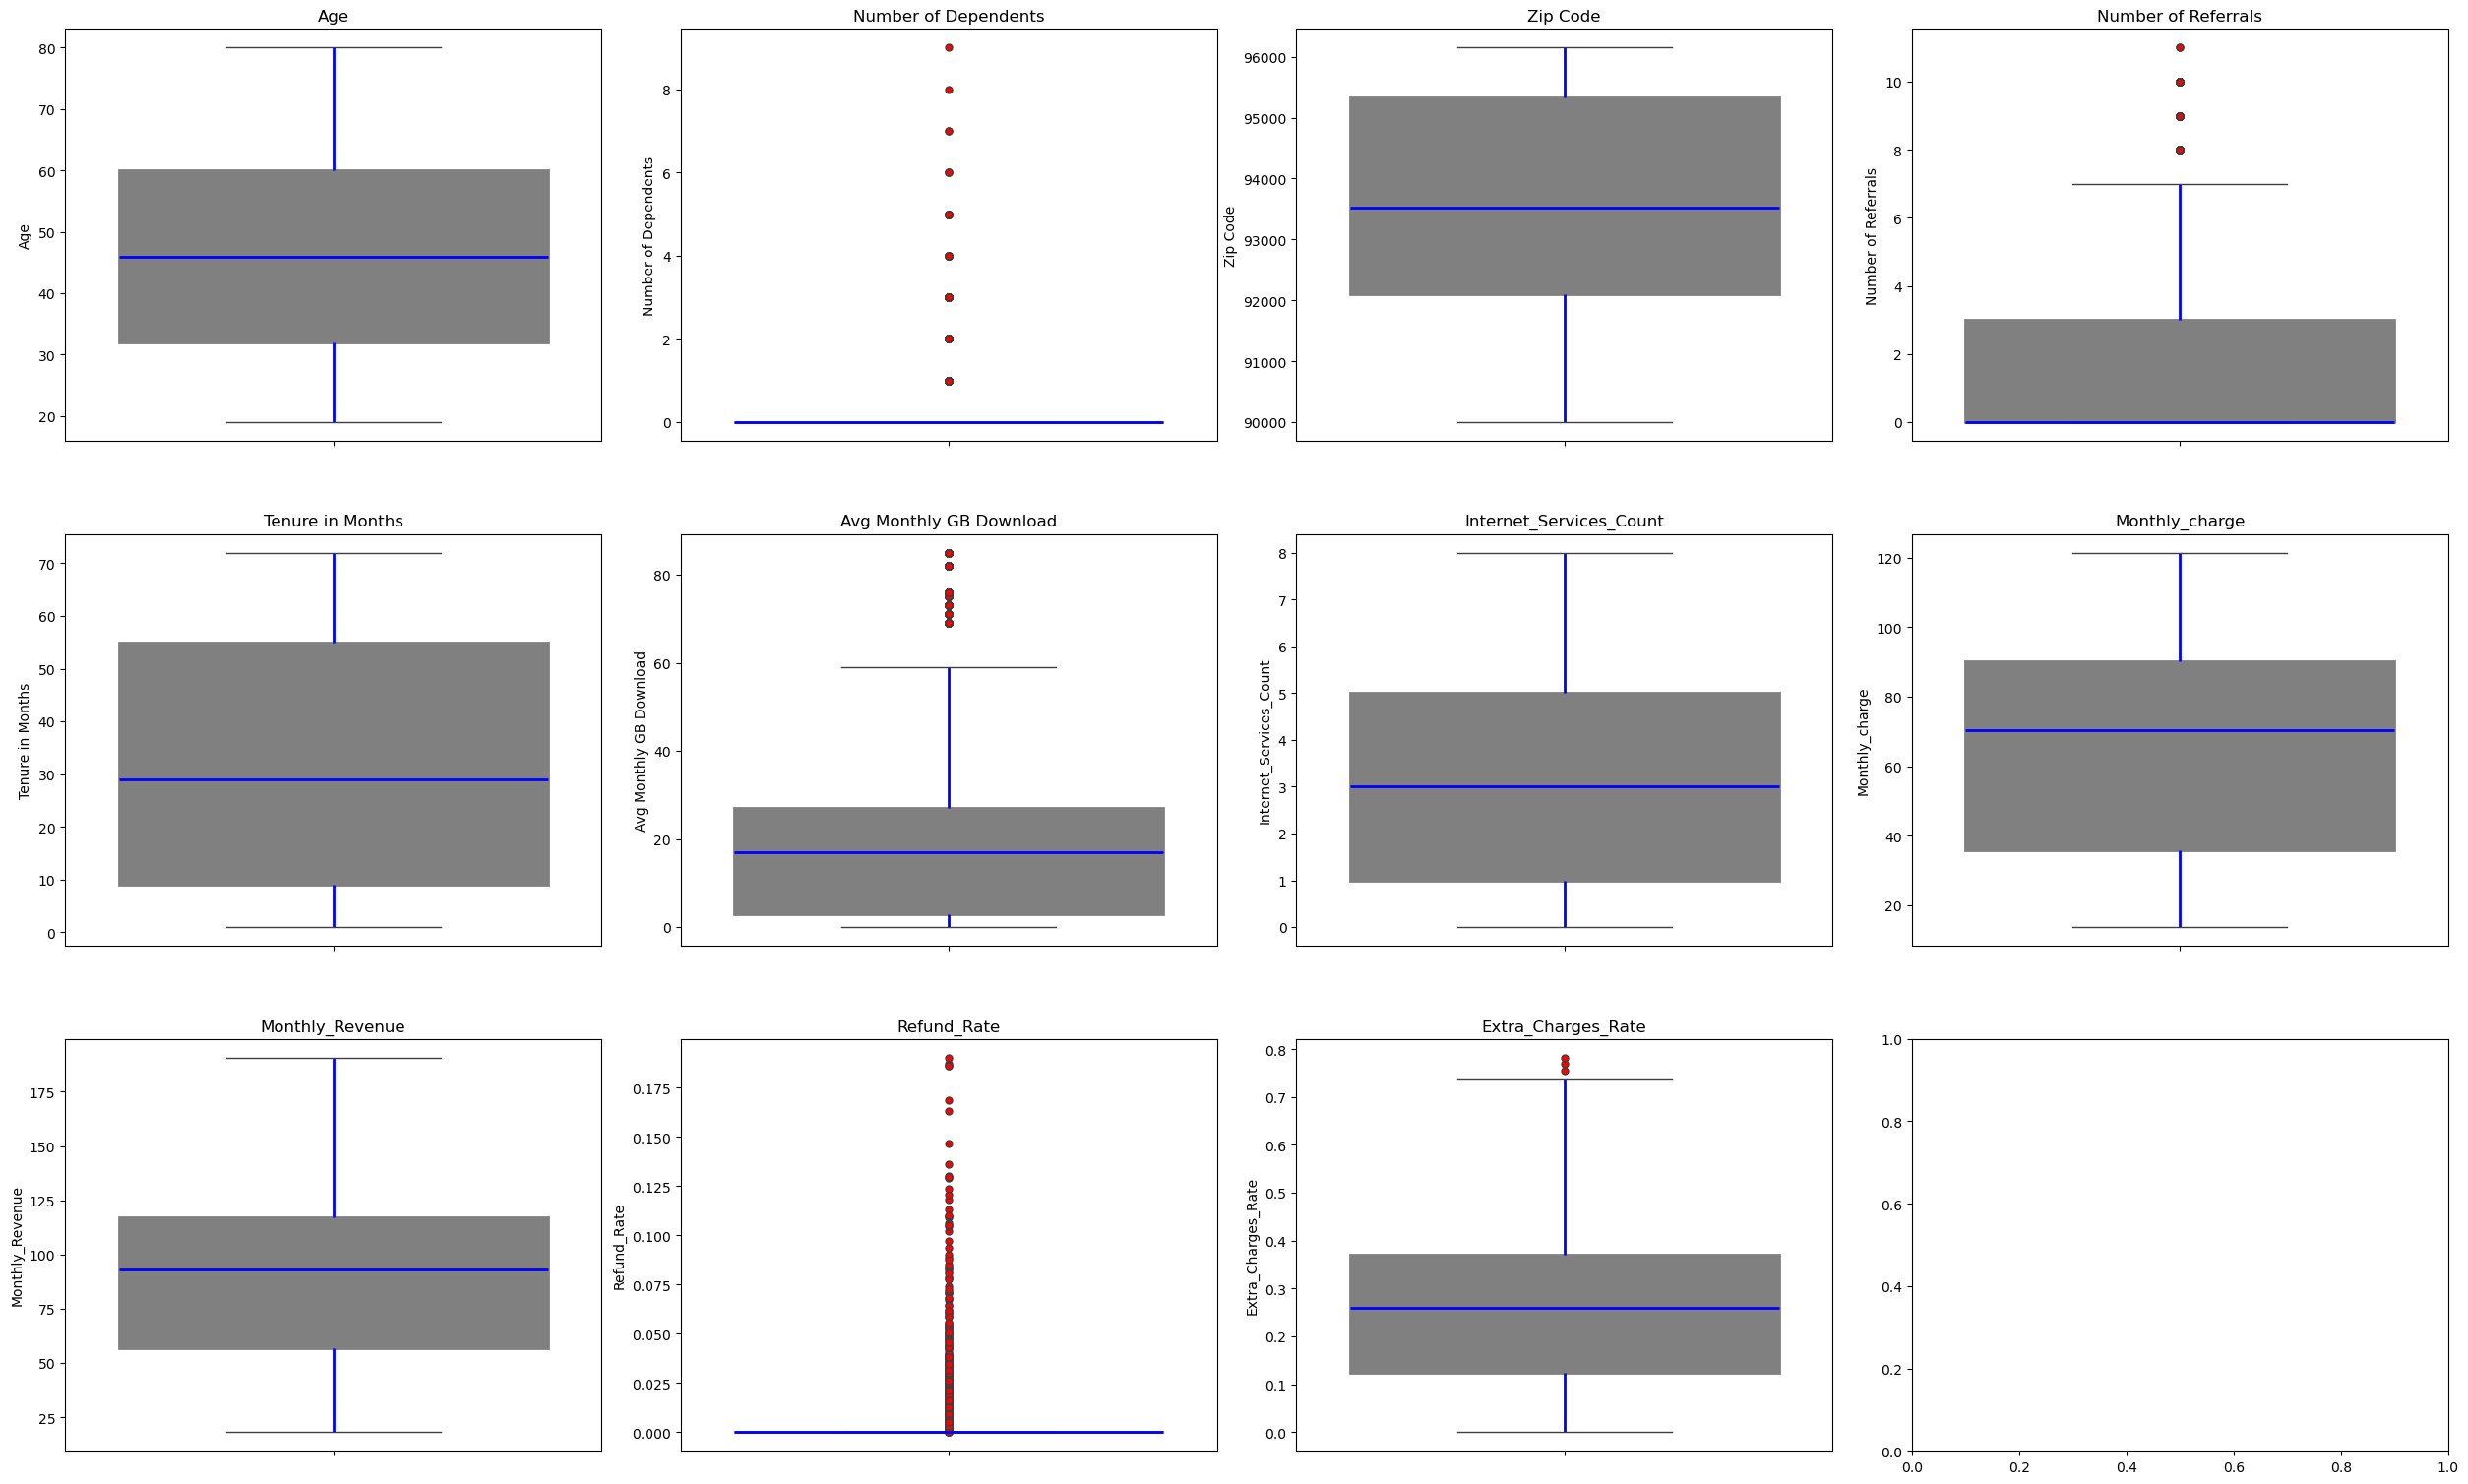

In [2012]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(25, 15))
axs = axs.flatten()

flierprops = dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none')
whiskerprops = dict(color='blue', linewidth=2)
boxprops = dict(color='grey', linewidth=2)
medianprops = dict(color='blue', linewidth=2)

index = 0
for k, v in new_vars_quanti.items():
    sns.boxplot(y=v, ax=axs[index],
                flierprops=flierprops,
                whiskerprops=whiskerprops,
                boxprops=boxprops,
                medianprops=medianprops)
    
    axs[index].set_title(k)
    index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5)
plt.show()

## Outliers

In [2014]:
Q1 = new_vars_quanti.quantile(0.25)
Q3 = new_vars_quanti.quantile(0.75)
IQR = Q3 - Q1

# Définir les bornes
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Détection des outliers
outliers = (new_vars_quanti < lower_bound) | (new_vars_quanti > upper_bound)
outliers.sum()  # nombre d'outliers par variable

Age                           0
Number of Dependents       1627
Zip Code                      0
Number of Referrals         676
Tenure in Months              0
Avg Monthly GB Download     362
Internet_Services_Count       0
Monthly_charge                0
Monthly_Revenue               0
Refund_Rate                 525
Extra_Charges_Rate            3
dtype: int64